In [ ]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100
$(".output").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox', true);
            var div = document.createElement('div');
            var checkbox = document.createElement("input");
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

In [1]:
import pandas as pd
import os
from collections import defaultdict
from random import choice, sample
import pickle as pkl
from sklearn.metrics.pairwise import cosine_similarity
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy import stats
from matplotlib.patches import Rectangle
import seaborn as sns
from tqdm import tqdm
import random

In [2]:
scripts_dir = os.getcwd()
os.chdir("../data")
data_dir = os.getcwd()
os.chdir("../results")
results_dir = os.getcwd()
os.chdir("../metadata")
meta_dir = os.getcwd()
os.chdir(scripts_dir)


speech_lengths = ["full", 60, 30, 10, 5, 3, 1]
NUM_PAIRS = 3
GENERATE_GRAPHS = True
speaker_meta_path = os.path.join(meta_dir, "person.csv")


meta_df = pd.read_csv(speaker_meta_path)
iid_to_gen = dict(map(lambda x: (x[0], "F") if x[1] == "kvinna" else (x[0], "M"), meta_df[["Id", "Kön"]].itertuples(index=False, name=None)))

In [4]:
def get_cossim_df(num_pairs, parquet_path, save_path):
    print(f"Processing {save_path}")
    #
    NUM_PAIRS = num_pairs
    df = pd.read_parquet(os.path.join(meta_dir, parquet_path))
    #
    if "age" in df.columns:
        df["gender"] = df.intressent_id.apply(lambda x: iid_to_gen[x])
    else:
        df["gender1"] = df.intressent_id1.apply(lambda x: iid_to_gen[x])
        df["gender2"] = df.intressent_id2.apply(lambda x: iid_to_gen[x])
    #
    danfs_to_use = set()
    for i in range(1, NUM_PAIRS+1):
        danfs_to_use.update(set(reduce(lambda x, y: list(x) + list(y), list(map(set, df[f"pair_{i}"].tolist())))))
    #
    dokids_to_use = set(i.split("_")[0] for i in danfs_to_use)
    #
    all_embs = dict()
    print("Getting embeddings")
    any_dir = os.path.join(data_dir, str(1))
    embeddings = tqdm(speech_lengths, total=len(speech_lengths)*len(next(os.walk(any_dir))[2]))
    for speech_length in speech_lengths:
#         print(f"Processing {speech_length}")
        length_dir = os.path.join(data_dir, str(speech_length))
        embs = dict()
        embeddings.set_postfix(speech_length=speech_length)
        for emb_path in next(os.walk(length_dir))[2]:
            if emb_path.split("_")[1].split(".")[0] in dokids_to_use:
                with open(os.path.join(length_dir, emb_path), "rb") as infile:
                    dokid_embs = pkl.load(infile)
                for danf, emb in dokid_embs.items():
                    if danf in danfs_to_use:
                        embs[danf] = emb
            embeddings.update(1)
        all_embs[speech_length] = embs
    embeddings.close()
    
    print("Processing cossim_scores")
    cossim_scores = tqdm(speech_lengths, 
                         total=len(speech_lengths)*len(speech_lengths)*NUM_PAIRS)
    for speech_length_1 in speech_lengths:
#         print(f"Processing {speech_length_1}")
        for speech_length_2 in speech_lengths:
#             print(f"\tProcessing {speech_length_2}")
            cossim_scores.set_postfix(speech_length_1=speech_length_1,
                                   speech_length_2=speech_length_2)
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            for i in range(1, NUM_PAIRS+1):
                df[f"score_{i}_{col_id}"] = df[f"pair_{i}"].apply(
                    lambda y: cosine_similarity(all_embs[speech_length_1][y[0]],
                                                all_embs[speech_length_2][y[1]])[0][0])
                cossim_scores.update(1)
            df[f"score_mean_{col_id}"] = df[
                [f"score_{i}_{col_id}" for i in range(1, NUM_PAIRS+1)]].apply(
                lambda x: sum(x)/NUM_PAIRS, axis=1)
    cossim_scores.close()
        #
    if GENERATE_GRAPHS:
        for speech_length in speech_lengths:
            plt.hist(list(reduce(lambda x, y: x + y, [df[f"score_{i}_{speech_length}"].tolist() for i in range(1, NUM_PAIRS+1)])))
            # plt.title(f'{(" ").join(save_path.split("_"))} cosine similarity scores for {speech_length} speech length')
            plt.savefig(os.path.join(results_dir, "unneeded", f"{save_path}_{speech_length}_cossim_score.svg"))
            plt.close()
        
        for i, speech_length in enumerate(speech_lengths):
            plt.hist(list(reduce(lambda x, y: x + y, [df[f"score_{i}_{speech_length}"].tolist() for i in range(1, NUM_PAIRS+1)])),
                     label=f"{speech_length}",
                     bins=np.arange(-0.2, 1, 0.02))
        # plt.title(f'{(" ").join(save_path.split("_"))} cosine similarity scores')
        plt.legend()
        plt.savefig(os.path.join(results_dir, "overal average cossim scores", f"{save_path}_all_cossim_score.svg"))
        plt.close()
        #
    print()
    return df


def get_cossim_dfs(split):
    across_age_df = get_cossim_df(num_pairs=3,
                                parquet_path=f"{split}_within_speaker_across_age_comparisons.parquet",
                                save_path=f"{split}_within_speaker_across_age")
    #
    within_age_df = get_cossim_df(num_pairs=3,
                                parquet_path=f"{split}_within_speaker_within_age_comparisons.parquet",
                                save_path=f"{split}_within_speaker_within_age")
    #
    across_speaker_df = get_cossim_df(num_pairs=1,
                                    parquet_path=f"{split}_across_speaker_comparisons.parquet",
                                    save_path=f"{split}_across_speaker")
    #
    across_speaker_within_age_df = get_cossim_df(num_pairs=1,
                                                parquet_path=f"{split}_across_speaker_within_age_comparisons.parquet",
                                                save_path=f"{split}_across_speaker_within_age")
    #
    cossims = {"across speaker across age": [],
               "within speaker across age": [],
               "within speaker within age": []}
    for i, speech_length in enumerate(speech_lengths):
        for key, df, num_pairs in [("across speaker across age", across_speaker_df, 1),
                                   ("within speaker across age", across_age_df, 3),
                                   ("within speaker within age", within_age_df, 3)]:
            
            cossims[key] += list(reduce(lambda x, y: x + y, [df[f"score_{i}_{speech_length}"].tolist() for i in range(1, num_pairs+1)]))
    for df_type, cossims_list in cossims.items():
        plt.hist(cossims_list, label=df_type, bins=np.arange(-0.2, 1, 0.02))
    # plt.title(f'cosine similarity scores for all speech lengths combined')
    plt.legend()
    plt.savefig(os.path.join(results_dir, 
                             "overal average cossim scores", 
                             f"{split}_all_speech_lengths_all_cossim_score.svg"))
    plt.close()
    #
    return across_age_df, within_age_df, across_speaker_df, across_speaker_within_age_df

created = True

if not created:
    train_across_age_df, train_within_age_df, train_across_speaker_df, train_across_speaker_within_age_df = get_cossim_dfs("train")
    dev_across_age_df, dev_within_age_df, dev_across_speaker_df, dev_across_speaker_within_age_df = get_cossim_dfs("dev")
    test_across_age_df, test_within_age_df, test_across_speaker_df, test_across_speaker_within_age_df = get_cossim_dfs("test")

    train_dfs = [train_across_age_df, train_within_age_df, train_across_speaker_df, train_across_speaker_within_age_df]
    dev_dfs = [dev_across_age_df, dev_within_age_df, dev_across_speaker_df, dev_across_speaker_within_age_df]
    test_dfs = [test_across_age_df, test_within_age_df, test_across_speaker_df, test_across_speaker_within_age_df]

    all_dfs = [("train", train_dfs), ("dev", dev_dfs), ("test", test_dfs)]

    for split, df_to_save in all_dfs:
        with open(os.path.join(data_dir, f"{split}_dfs.pkl"), "wb") as outfile:
            pkl.dump(df_to_save, outfile)

else:
    with open(os.path.join(data_dir, "train_dfs.pkl"), "rb") as infile:
        train_across_age_df, train_within_age_df, train_across_speaker_df, train_across_speaker_within_age_df = pkl.load(infile)

    with open(os.path.join(data_dir, "dev_dfs.pkl"), "rb") as infile:
        dev_across_age_df, dev_within_age_df, dev_across_speaker_df, dev_across_speaker_within_age_df = pkl.load(infile)

    with open(os.path.join(data_dir, "test_dfs.pkl"), "rb") as infile:
        test_across_age_df, test_within_age_df, test_across_speaker_df, test_across_speaker_within_age_df = pkl.load(infile)

 11%|█         | 7440/68495 [00:40<01:49, 557.73it/s, speech_length=full]

In [5]:
def get_best_threshold_n_roc(df_within, df_across, split="train", NUM_PAIRS=3, mode="across"):
    """get metrics when comparing (across speakers) vs (within speakers at the same age)"""
    if mode == "across":
        mode = ""
    else:
        mode = "_within"
    scores = dict()
    for speech_length in speech_lengths:
        within_scores = list(reduce(lambda x, y: x + y, [df_within[f"score_{i}_{speech_length}"].tolist() for i in range(1, NUM_PAIRS+1)]))
        across_scores = df_across[f"score_1_{speech_length}"].tolist()
        across_n_within_age_scores = across_scores + within_scores
        true_scores = [0 for _ in range(len(across_scores))] + [1 for _ in range(len(within_scores))]
        fpr, tpr, thresholds = roc_curve(true_scores, across_n_within_age_scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        #
        eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        threshold = interp1d(fpr, thresholds)(eer)
        threshold = float(threshold)
        #
        scores[f"{speech_length}"] = (threshold, (fpr, tpr, thresholds))
        #
        if GENERATE_GRAPHS:
            # plt.title(f'ROC curve for {speech_length} speech length')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.savefig(os.path.join(results_dir, "roc curves", f"{split}_AOC_CURVE_within_speaker_within_age_VS_across_speaker{mode}_{speech_length}.svg"))
            plt.close()
            #
    within_scores_all = []
    across_scores_all = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            within_scores = list(reduce(lambda x, y: x + y, 
                                        [df_within[f"score_{i}_{col_id}"].tolist() \
                                         for i in range(1, NUM_PAIRS+1)]))
            across_scores = df_across[f"score_1_{col_id}"].tolist()
            
            within_scores_all += within_scores
            across_scores_all += across_scores
    across_n_within_age_scores = across_scores_all + within_scores_all
    true_scores = [0 for _ in range(len(across_scores_all))] + [1 for _ in range(len(within_scores_all))]
    fpr, tpr, thresholds = roc_curve(true_scores, across_n_within_age_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    print(eer)
    threshold = interp1d(fpr, thresholds)(eer)
    threshold = float(threshold)
    scores["all"] = (threshold, (fpr, tpr, thresholds))
    if GENERATE_GRAPHS:
        # plt.title(f'ROC curve for all speech lengths')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.savefig(os.path.join(results_dir, "roc curves", f"{split}_AOC_CURVE_within_speaker_within_age_VS_across_speaker{mode}_all_speech_lengths.svg"))
        plt.close()
    return scores

scores = get_best_threshold_n_roc(train_within_age_df, train_across_speaker_df, "train", 3)

0.07142428219711595


In [6]:
len(sorted(scores["all"][1][2]))
t = scores["all"][0]
print(t)
scores["all"][1][0]
zipped = [(scores["all"][1][0][i], scores["all"][1][1][i], scores["all"][1][2][i]) \
 for i in range(len(scores["all"][1][0]))]
list(filter(lambda x: x[2] >= t, zipped))[-1]

0.468029499053955


(0.0714157037342049, 0.9285757178028841, 0.46804094314575195)

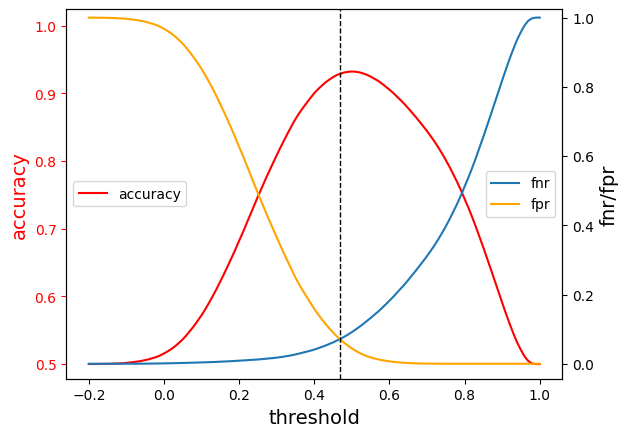

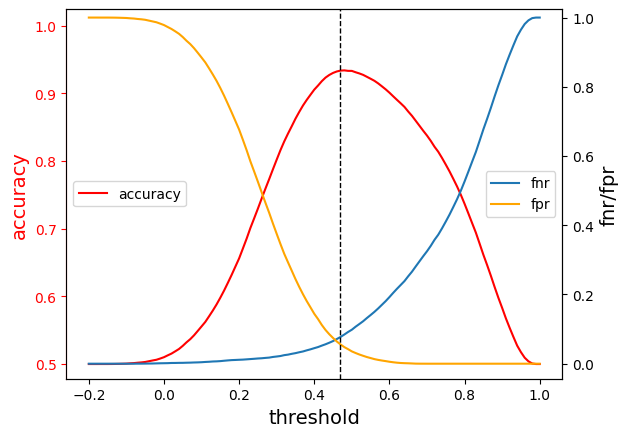

In [7]:
def vary_threshold_graph(df_within, df_across, global_scores, split="train", NUM_PAIRS=3, mode="across"):
    # """get metrics when comparing (across speakers) vs (within speakers at the same age)"""
    def calculate_threshold_scores(across_scores, within_scores):
        threshold_scores = []
        for threshold in np.arange(-0.2, 1.01, 0.01):
            thresh_across_scores = [1 if i >= threshold else 0 for i in across_scores]
            thresh_within_scores = [1 if i >= threshold else 0 for i in within_scores]
            across_n_within_age_scores = thresh_across_scores + thresh_within_scores
            true_scores = [0 for _ in range(len(thresh_across_scores))] + [1 for _ in range(len(thresh_within_scores))]
            accuracy = sum([1 if across_n_within_age_scores[i] == true_scores[i] else 0 for i in range(len(true_scores))])/len(true_scores)
            false_negs = sum([1 if (across_n_within_age_scores[i] != true_scores[i]) and (true_scores[i] == 1) else 0
                              for i in range(len(true_scores))])
            fnr = false_negs/len(thresh_within_scores)
            false_poss = sum([1 if (across_n_within_age_scores[i] != true_scores[i]) and (true_scores[i] == 0) else 0
                              for i in range(len(true_scores))])
            fpr = false_poss/len(thresh_across_scores)
            data = (threshold, accuracy, false_negs, false_poss, fnr, fpr)
            threshold_scores.append(data)
            
        return threshold_scores
    
    def generate_graph(threshold_scores, speech_length):
        fig, ax = plt.subplots()
        thresholds = [i[0] for i in threshold_scores]
        accs = [i[1] for i in threshold_scores]
        fnrs = [i[4] for i in threshold_scores]
        fprs = [i[5] for i in threshold_scores]
        #
        ax.plot(thresholds, accs, color="red", label="accuracy")
        ax.set_xlabel("threshold", fontsize = 14)
        ax.set_ylabel("accuracy",
                    color="red",
                    fontsize=14)
        bottom, top = plt.gca().get_ylim()[0], 1.024396551724138
        ax.set_ylim(bottom=bottom, top=top)
        ax.spines['left'].set_color('red')
        ax.yaxis.label.set_color('red')
        ax.tick_params(axis='y', colors='red')
        ax.set_ylim(bottom=bottom, top=top)
        plt.legend(loc="center left")
        #
        ax2 = ax.twinx()
        ax2.plot(thresholds, fnrs, label="fnr")
        ax2.set_ylabel("fnr/fpr",color="black",fontsize=14)
        #
        ax2.plot(thresholds, fprs, color="orange", label="fpr")
        ax2.set_ylim(bottom=(bottom-0.5)*2, top=top)
        if speech_length == "all":
            threshold = global_scores["all"][0]
            ax2.axvline(threshold, color='k', linestyle='dashed', linewidth=1)
        plt.legend()
        # plt.title(f"Accuracy VS FNR/FPR at different thresholds for {speech_length} speech length")
        fig.savefig(os.path.join(results_dir, "acc vs fnr and fpr graphs", f'{split}_acc_vs_fnr_n_fpr_within_age_within_age_VS_across_speaker{mode}_{speech_length}.svg'),
                    bbox_inches='tight')
        if speech_length == "all":
            plt.show()
        plt.close()
        
    if mode == "across":
        mode = ""
    else:
        mode = "_within"
        
    scores = dict()
    
    for speech_length in speech_lengths:
        within_scores = list(reduce(lambda x, y: x + y, [df_within[f"score_{i}_{speech_length}"].tolist() for i in range(1, NUM_PAIRS+1)]))
        across_scores = df_across[f"score_1_{speech_length}"].tolist()
        
        scores[f"{speech_length}"] = calculate_threshold_scores(across_scores, within_scores)
        
        if GENERATE_GRAPHS:
            generate_graph(scores[f"{speech_length}"], speech_length)
    
    within_scores_all = []
    across_scores_all = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
                
            within_scores = list(reduce(lambda x, y: x + y, 
                                        [df_within[f"score_{i}_{col_id}"].tolist() \
                                         for i in range(1, NUM_PAIRS+1)]))
            across_scores = df_across[f"score_1_{col_id}"].tolist()
            
            within_scores_all += within_scores
            across_scores_all += across_scores
            
    scores["all"] = calculate_threshold_scores(across_scores_all, within_scores_all)
    
    if GENERATE_GRAPHS:
        generate_graph(scores["all"], "all")
        
    return scores


thresh_scores = vary_threshold_graph(train_within_age_df, train_across_speaker_df, scores, "train", 3)
thresh_scores_dev = vary_threshold_graph(dev_within_age_df, dev_across_speaker_df, scores, "dev", 3)

(0.5000000000000007, 0.9322172753086102)
0.5000000000000007
0.2967560972883627 0.7669093848461236


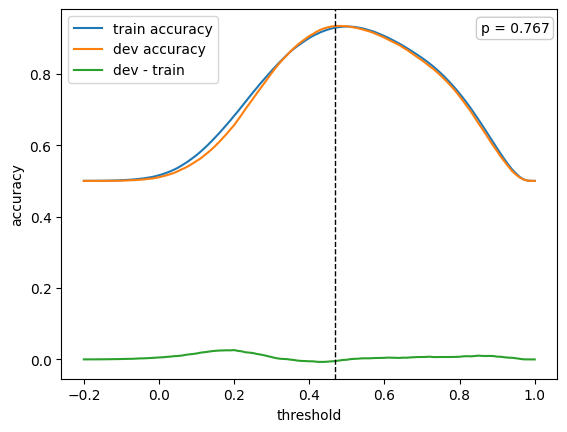

In [8]:
def graph_diff_thresh_scores(thresh_scores, thresh_scores_dev):
    train_accs = [thresh_score[1] for thresh_score in thresh_scores["all"]]
    dev_accs = [thresh_score[1] for thresh_score in thresh_scores_dev["all"]]
    diff = np.array(train_accs) - np.array(dev_accs)
    threshes = [thresh_score[0] for thresh_score in thresh_scores_dev["all"]]
    print(max([(thresh_score[0], thresh_score[1])\
                 for thresh_score in thresh_scores["all"]], key=lambda x: x[1]))
    threshold = max([(thresh_score[0], thresh_score[1])\
                 for thresh_score in thresh_scores["all"]],
                    key=lambda x: x[1])[0]
    print(threshold)
    stat, pvalue = stats.ttest_ind(train_accs, dev_accs)
    print(stat, pvalue)
    plt.plot(threshes, train_accs, label="train accuracy")
    plt.plot(threshes, dev_accs, label="dev accuracy")
    plt.plot(threshes, diff, label="dev - train")
    plt.legend()
    props = dict(boxstyle='round', facecolor='white', alpha=0.2)
    text = f"p = {pvalue:.3f}"
    y_lim = plt.gca().get_ylim()[1]*0.965
    x_lim = plt.gca().get_xlim()[1]*0.98
    plt.text(x_lim, y_lim, text, horizontalalignment="right", verticalalignment="top", bbox=props)
    # plt.title(f"Train and dev accuracy at different thresholds for all speech lengths")
    plt.xlabel('threshold')
    plt.ylabel('accuracy')
    global scores
    threshold = scores["all"][0]
    plt.axvline(threshold, color='k', linestyle='dashed', linewidth=1)
    plt.savefig(os.path.join(results_dir, 
                             "acc vs fnr and fpr graphs", 
                             f'train_VS_dev_acc_within_age_VS_across_speaker_all_speech_lengths.svg'),
                bbox_inches='tight')
    plt.show()
    plt.close()
    
graph_diff_thresh_scores(thresh_scores, thresh_scores_dev)

In [9]:
def add_threshold_accs_to_df(within_age_df, across_age_df, across_speaker_df, thresholds, num_pairs=3):
    # TODO: add threshold calculated based on all speech lengths
    for speech_length in speech_lengths:
        threshold = thresholds[f"{speech_length}"][0]
        for i in range(1, num_pairs+1):
            across_age_df[f"thresh_score_{i}_{speech_length}"] = across_age_df[\
                f"score_{i}_{speech_length}"].apply(lambda x: 1 if x >= threshold else 0)
        for i in range(1, num_pairs+1):
            within_age_df[f"thresh_score_{i}_{speech_length}"] = within_age_df[\
                f"score_{i}_{speech_length}"].apply(lambda x: 1 if x >= threshold else 0)
        across_speaker_df[f"thresh_score_1_{speech_length}"] = across_speaker_df[\
            f"score_1_{speech_length}"].apply(lambda x: 1 if x >= threshold else 0)
    
    threshold = thresholds["all"][0]
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            for i in range(1, num_pairs+1):
                across_age_df[f"thresh_score_{i}_{col_id}_all"] = across_age_df[\
                    f"score_{i}_{col_id}"].apply(lambda x: 1 if x >= threshold else 0)
            for i in range(1, num_pairs+1):
                within_age_df[f"thresh_score_{i}_{col_id}_all"] = within_age_df[\
                    f"score_{i}_{col_id}"].apply(lambda x: 1 if x >= threshold else 0)
            across_speaker_df[f"thresh_score_1_{col_id}_all"] = across_speaker_df[\
                f"score_1_{col_id}"].apply(lambda x: 1 if x >= threshold else 0)


add_threshold_accs_to_df(train_within_age_df, train_across_age_df, train_across_speaker_df, scores, 3)
add_threshold_accs_to_df(dev_within_age_df, dev_across_age_df, dev_across_speaker_df, scores, 3)
add_threshold_accs_to_df(test_within_age_df, test_across_age_df, test_across_speaker_df, scores, 3)

C:\Users\mayan\AppData\Local\Temp\ipykernel_8576\1175936245.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  across_age_df[f"thresh_score_{i}_{col_id}_all"] = across_age_df[\
C:\Users\mayan\AppData\Local\Temp\ipykernel_8576\1175936245.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  within_age_df[f"thresh_score_{i}_{col_id}_all"] = within_age_df[\
C:\Users\mayan\AppData\Local\Temp\ipykernel_8576\1175936245.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [10]:
def overall_accuracy(across_age_df, across_speaker_df, thresholds, num_pairs=3):
    def get_data(across_age_preds, across_speaker_preds):
        all_preds = across_age_preds + across_speaker_preds
        all_true = [1 for _ in range(len(across_age_preds))] + [0 for _ in range(len(across_speaker_preds))]
        #
        accuracy = sum([1 if all_preds[i] == all_true[i] else 0 for i in range(len(all_true))])/len(all_true)
        #
        false_negs = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 1) else 0
                            for i in range(len(all_true))])
        fnr = false_negs/len(across_age_preds)
        #
        false_poss = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 0) else 0
                            for i in range(len(all_true))])
        fpr = false_poss/len(across_speaker_preds)
        len_data = len(across_speaker_df)
        #
        data = (threshold, accuracy, false_negs, false_poss, fnr, fpr, len_data)
        
        return data
    
    scores = dict()
    for speech_length in speech_lengths:
        threshold = thresholds[f"{speech_length}"][0]
        #
        across_age_preds = list(reduce(lambda x, y: x + y, 
                                        [across_age_df[f"thresh_score_{i}_{speech_length}"].tolist() for i in range(1, num_pairs+1)]))
        across_speaker_preds = across_speaker_df[f"thresh_score_1_{speech_length}"].tolist()
        #
        scores[f"{speech_length}"] = get_data(across_age_preds, across_speaker_preds)
        
    threshold = thresholds["all"][0]
    across_age_preds_all = []
    across_speaker_preds_all = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            across_age_preds = list(reduce(lambda x, y: x + y, 
                                    [across_age_df[f"thresh_score_{i}_{col_id}_all"\
                                                  ].tolist() for i in range(1, num_pairs+1)]))
            across_speaker_preds = across_speaker_df[f"thresh_score_1_{col_id}_all"].tolist()
            #
            across_age_preds_all += across_age_preds
            across_speaker_preds_all += across_speaker_preds
    
            scores[f"{speech_length_1}_{speech_length_2}"] = get_data(across_age_preds,
                                                                      across_speaker_preds)
    scores["all"] = get_data(across_age_preds_all, across_speaker_preds_all)
    return scores


train_overall_accuracies = overall_accuracy(train_across_age_df, train_across_speaker_df, scores, 3)
dev_overall_accuracies = overall_accuracy(dev_across_age_df, dev_across_speaker_df, scores, 3)
test_overall_accuracies = overall_accuracy(test_across_age_df, test_across_speaker_df, scores, 3)

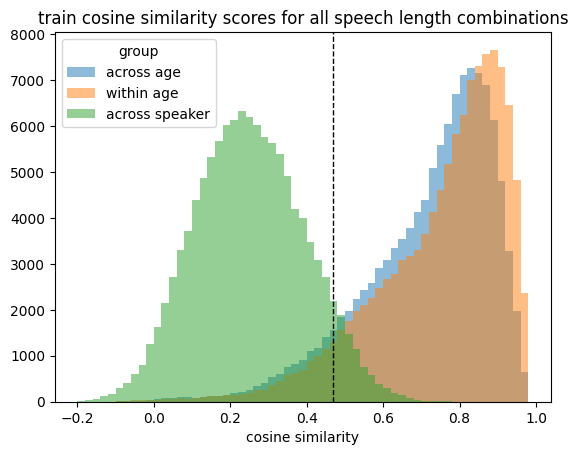

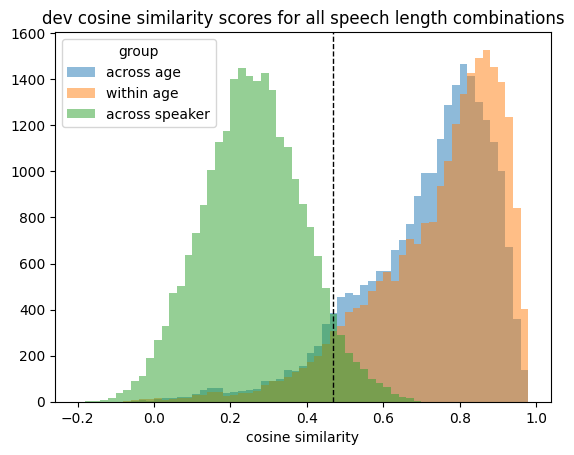

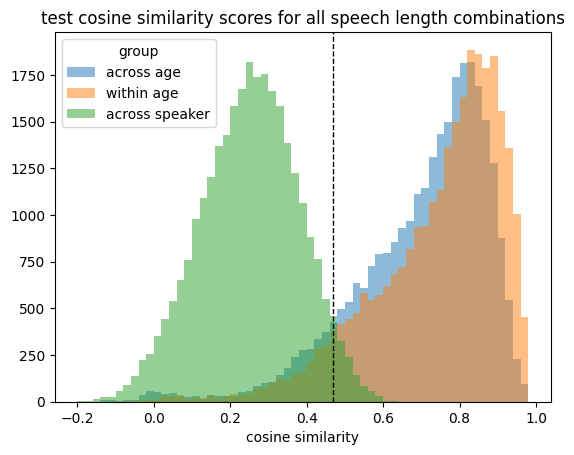

In [31]:
def graph_cossims_all_speech_lengths(within_age_df, across_age_df, across_speaker_df, thresholds, num_pairs=3, split="train"):
    threshold = thresholds["all"][0]
    across_age_scores = []
    within_age_scores = []
    across_speaker_scores = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            for i in range(1, num_pairs+1):
                across_age_scores += across_age_df[\
                    f"score_{i}_{col_id}"].tolist()
            for i in range(1, num_pairs+1):
                within_age_scores += within_age_df[\
                    f"score_{i}_{col_id}"].tolist()
            across_speaker_scores += across_speaker_df[\
                f"score_1_{col_id}"].tolist()
            
    plt.hist(across_age_scores,
             label="across age",
             bins=np.arange(-0.2, 1, 0.02),
             alpha=0.5)
    plt.hist(within_age_scores,
             label="within age",
             bins=np.arange(-0.2, 1, 0.02),
             alpha=0.5)
    plt.hist(across_speaker_scores,
             label="across speaker",
             bins=np.arange(-0.2, 1, 0.02),
             alpha=0.5)
    plt.title(f"{split} cosine similarity scores for all speech length combinations")
    plt.legend(title="group")
    plt.axvline(threshold, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel("cosine similarity")
    plt.savefig(os.path.join(results_dir, 
                             "overal average cossim scores", 
                             f"{split}_all_cossim_score.svg"))
    plt.show()
    plt.close()


graph_cossims_all_speech_lengths(train_within_age_df, train_across_age_df, train_across_speaker_df, scores, 3, "train")
graph_cossims_all_speech_lengths(dev_within_age_df, dev_across_age_df, dev_across_speaker_df, scores, 3, "dev")
graph_cossims_all_speech_lengths(test_within_age_df, test_across_age_df, test_across_speaker_df, scores, 3, "test")

In [12]:
def chart_diff_length_accuracies(overal_accuracies):#, metric):
    # (threshold, accuracy, false_negs, false_poss, fnr, fpr, len_data)
    metric_to_idx = {"accuracy": 1, "false_negs": 2, 
                     "false_poss": 3, "fnr": 4, "fpr": 5}
    print(f"Average performance")
    print(f"Threshold: {overal_accuracies['all'][0]:.2f}, " \
          + ", ".join(f"{metric}: {overal_accuracies['all'][idx]:.2f}" for metric, idx in metric_to_idx.items()))
    for metric, idx in metric_to_idx.items():
#     idx = metric_to_idx[metric]
#     if idx == 2 or idx == 3:
#         total = overal_accuracies["all"][6]
#     else:
#         total = 1.00
        print(f"{metric} metric")
        if idx == 2 or idx == 3:
            print("     |" \
                  + " ".join(f"{speech_length:>8}" for speech_length in speech_lengths[::-1])\
                  + f" |{'sum':>8}")
        else:
            print("     |" \
                  + " ".join(f"{speech_length:>8}" for speech_length in speech_lengths[::-1])\
                  + f" |{'mean':>8}")
        print("-"*78)
        sum_accuracies = np.zeros(8)
        for speech_length_1 in speech_lengths[::-1]:
            accuracies = []
            for speech_length_2 in speech_lengths[::-1]:
                key = f"{speech_length_1}_{speech_length_2}"
                accuracies.append(overal_accuracies[key][idx])
    #             if speech_length_2 == "full":
    #                 accuracies.append(overal_accuracies[key][idx])
    #             elif speech_length_1 == "full":
    #                 accuracies.append(" ")
    #             elif int(speech_length_1) > int(speech_length_2):
    #                 accuracies.append(" ")
    #             else:
    #                 accuracies.append(overal_accuracies[key][idx])
            if idx == 2 or idx == 3:
                print(f"{speech_length_1:>4} |" \
                      + " ".join([f"{acc:8}" if acc != " " else " "*8 for acc in accuracies])\
                      + f" |{np.sum(accuracies):>8.0f}")
                sum_accuracies += accuracies + [np.sum(accuracies)]
            else:
                print(f"{speech_length_1:>4} |" \
                      + " ".join([f"{acc:8.2f}" if acc != " " else " "*8 for acc in accuracies])\
                      + f" |{np.mean(accuracies):>8.2f}")
                sum_accuracies += accuracies + [np.mean(accuracies)]
        print("-"*78)
        if idx == 2 or idx == 3:
            mean_accuracies = sum_accuracies
            print(f"{'sum':>4} |" \
                  + " ".join([f"{acc:8.0f}" if acc != " " else " "*8 for acc in mean_accuracies[:-1]])\
                  + f" |{mean_accuracies[-1]:8.0f}")
        else:
            mean_accuracies = sum_accuracies / 7
            print(f"{'mean':>4} |" \
                  + " ".join([f"{acc:8.2f}" if acc != " " else " "*8 for acc in mean_accuracies[:-1]])\
                  + f" |{mean_accuracies[-1]:8.2f}")
        print()
    
print(f"{train_overall_accuracies['all'][0]:.2f}")
chart_diff_length_accuracies(train_overall_accuracies)#, "accuracy")
# chart_diff_length_accuracies(train_overall_accuracies, "false_negs")
# chart_diff_length_accuracies(train_overall_accuracies, "false_poss")
# chart_diff_length_accuracies(train_overall_accuracies, "fnr")
# chart_diff_length_accuracies(train_overall_accuracies, "fpr")

0.47
Average performance
Threshold: 0.47, accuracy: 0.92, false_negs: 10396.00, false_poss: 8325.00, fnr: 0.09, fpr: 0.07
accuracy metric
     |       1        3        5       10       30       60     full |    mean
------------------------------------------------------------------------------
   1 |    0.61     0.78     0.83     0.85     0.87     0.88     0.88 |    0.82
   3 |    0.78     0.96     0.97     0.97     0.96     0.96     0.96 |    0.94
   5 |    0.83     0.97     0.97     0.97     0.96     0.96     0.95 |    0.94
  10 |    0.86     0.97     0.97     0.96     0.95     0.94     0.94 |    0.94
  30 |    0.87     0.97     0.96     0.95     0.93     0.93     0.93 |    0.93
  60 |    0.88     0.97     0.96     0.94     0.93     0.93     0.93 |    0.93
full |    0.88     0.96     0.96     0.94     0.93     0.93     0.92 |    0.93
------------------------------------------------------------------------------
mean |    0.82     0.94     0.94     0.94     0.93     0.93     0.93 |  

Average performance
Threshold: 0.47, accuracy: 0.92, false_negs: 10396.00, false_poss: 8325.00, fnr: 0.09, fpr: 0.07


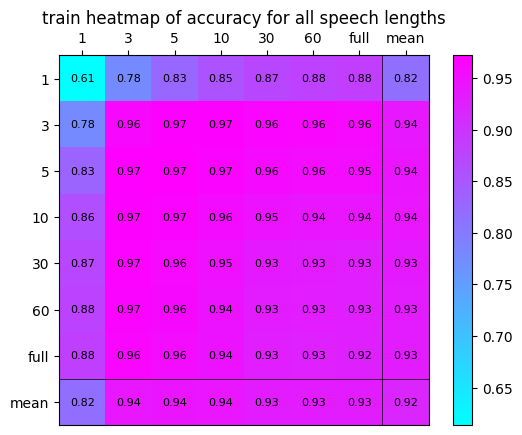

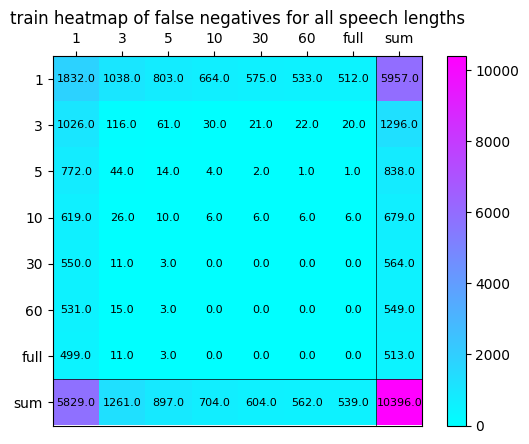

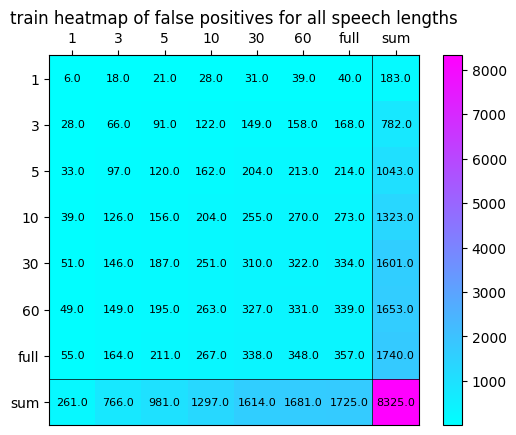

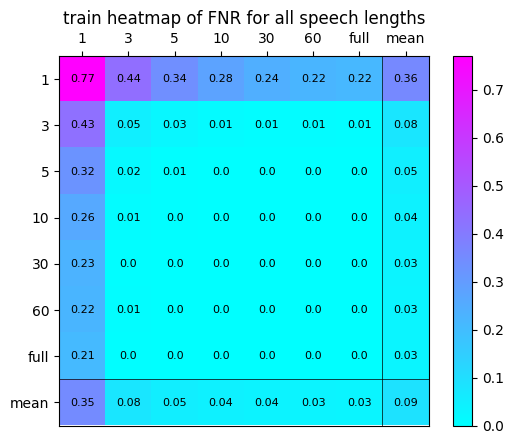

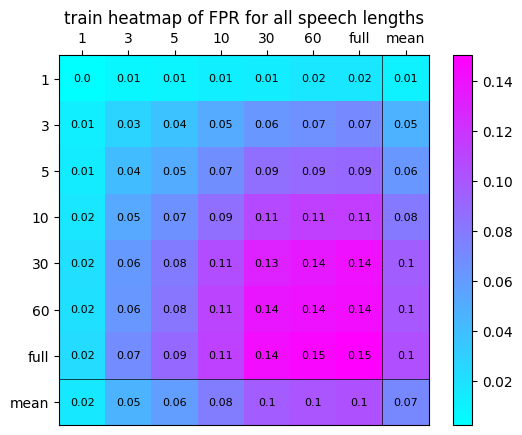

In [13]:
def graph_diff_length_accuracies(overal_accuracies, split="train"):#, metric):
    # (threshold, accuracy, false_negs, false_poss, fnr, fpr, len_data)
    metric_to_idx = {"accuracy": 1, "false_negs": 2, 
                     "false_poss": 3, "fnr": 4, "fpr": 5}
    print(f"Average performance")
    print(f"Threshold: {overal_accuracies['all'][0]:.2f}, " \
          + ", ".join(f"{metric}: {overal_accuracies['all'][idx]:.2f}" for metric, idx in metric_to_idx.items()))
    for metric, idx in list(metric_to_idx.items()):
        fig, ax = plt.subplots()
        all_accuracies = np.zeros((0,8))
        sum_accuracies = np.zeros(8)
        for speech_length_1 in speech_lengths[::-1]:
            accuracies = []
            for speech_length_2 in speech_lengths[::-1]:
                key = f"{speech_length_1}_{speech_length_2}"
                accuracies.append(overal_accuracies[key][idx])
            if idx == 2 or idx == 3:
                row = accuracies + [np.sum(accuracies)]
            else:
                row = accuracies + [np.mean(accuracies)]
            sum_accuracies += row
            all_accuracies = np.concatenate([all_accuracies, [row]], axis=0)
        all_accuracies = np.concatenate([all_accuracies, [sum_accuracies]], axis=0)
        if not (idx == 2 or idx == 3):
            all_accuracies[-1] /= 7
        im = ax.imshow(all_accuracies, cmap='cool')
        ax.xaxis.tick_top()
        if idx == 2 or idx == 3:
            ax.set_xticks(np.arange(8), speech_lengths[::-1] + ["sum"])
            ax.set_yticks(np.arange(8), speech_lengths[::-1] + ["sum"])
        else:
            ax.set_xticks(np.arange(8), speech_lengths[::-1] + ["mean"])
            ax.set_yticks(np.arange(8), speech_lengths[::-1] + ["mean"])
        for i in range(all_accuracies.shape[0]):
            for j in range(all_accuracies.shape[1]):
                text = ax.text(j, i, round(all_accuracies[i, j], 2),
                               ha="center", va="center", color="black",
                               fontsize=8)
        cbar = ax.figure.colorbar(im, ax=ax)
        titles = {"accuracy": "accuracy", "false_negs": "false negatives", 
                     "false_poss": "false positives", "fnr": "FNR", "fpr": "FPR"}
        ax.set_title(f"{split} heatmap of {titles[metric]} for all speech lengths")
        ax.axhline(y=6.5, color='black', linewidth=0.5)
        ax.axvline(x=6.5, color='black', linewidth=0.5)
        plt.savefig(os.path.join(results_dir, 
                                 "heatmaps", 
                                 f"{split}_{metric}_heatmap.svg"),
                    bbox_inches="tight")
        plt.show()
        plt.close()
        

graph_diff_length_accuracies(train_overall_accuracies, "train")

Average performance
Threshold: 0.47, accuracy: 0.93, false_negs: 2179.00, false_poss: 1346.00, fnr: 0.09, fpr: 0.06
accuracy metric
     |       1        3        5       10       30       60     full |    mean
------------------------------------------------------------------------------
   1 |    0.60     0.76     0.80     0.84     0.87     0.87     0.88 |    0.80
   3 |    0.78     0.96     0.97     0.98     0.97     0.97     0.97 |    0.94
   5 |    0.82     0.97     0.97     0.97     0.96     0.95     0.95 |    0.94
  10 |    0.87     0.98     0.97     0.97     0.96     0.96     0.95 |    0.95
  30 |    0.88     0.98     0.96     0.96     0.95     0.94     0.94 |    0.94
  60 |    0.88     0.98     0.96     0.96     0.94     0.94     0.93 |    0.94
full |    0.89     0.98     0.96     0.96     0.95     0.94     0.93 |    0.94
------------------------------------------------------------------------------
mean |    0.82     0.94     0.95     0.95     0.94     0.94     0.94 |    0.93

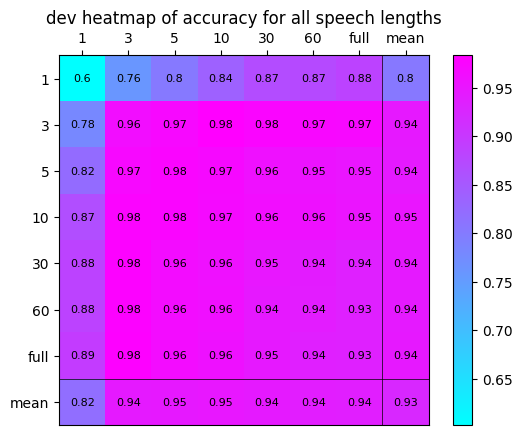

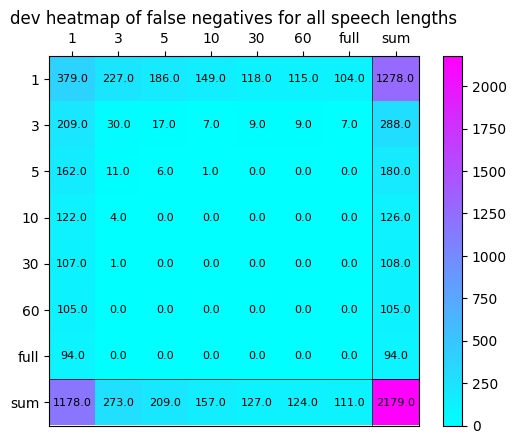

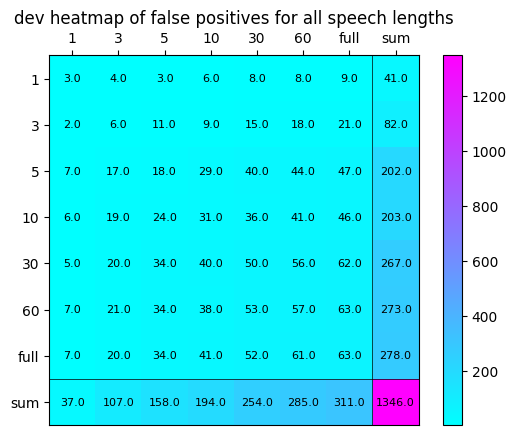

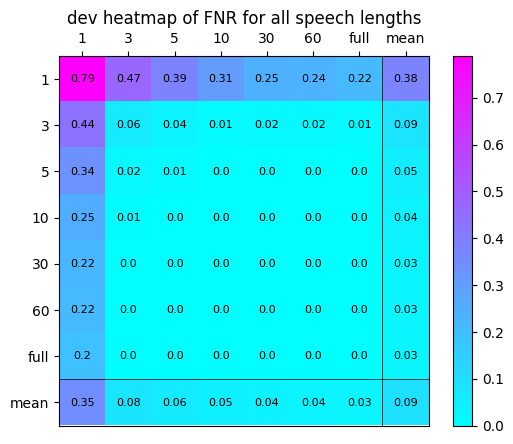

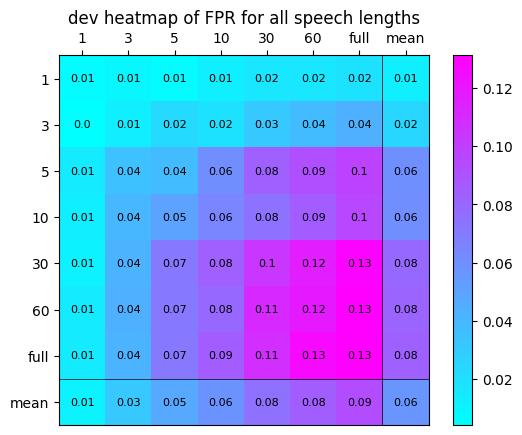

In [14]:
chart_diff_length_accuracies(dev_overall_accuracies)
graph_diff_length_accuracies(dev_overall_accuracies, "dev")

Average performance
Threshold: 0.47, accuracy: 0.93, false_negs: 2888.00, false_poss: 1153.00, fnr: 0.10, fpr: 0.04
accuracy metric
     |       1        3        5       10       30       60     full |    mean
------------------------------------------------------------------------------
   1 |    0.60     0.78     0.82     0.84     0.86     0.87     0.87 |    0.81
   3 |    0.76     0.96     0.97     0.98     0.98     0.98     0.98 |    0.94
   5 |    0.81     0.98     0.97     0.97     0.97     0.97     0.97 |    0.95
  10 |    0.85     0.98     0.98     0.97     0.97     0.97     0.96 |    0.96
  30 |    0.86     0.98     0.98     0.96     0.96     0.96     0.96 |    0.95
  60 |    0.87     0.98     0.98     0.96     0.96     0.96     0.95 |    0.95
full |    0.88     0.98     0.97     0.96     0.95     0.96     0.95 |    0.95
------------------------------------------------------------------------------
mean |    0.81     0.95     0.95     0.95     0.95     0.95     0.95 |    0.93

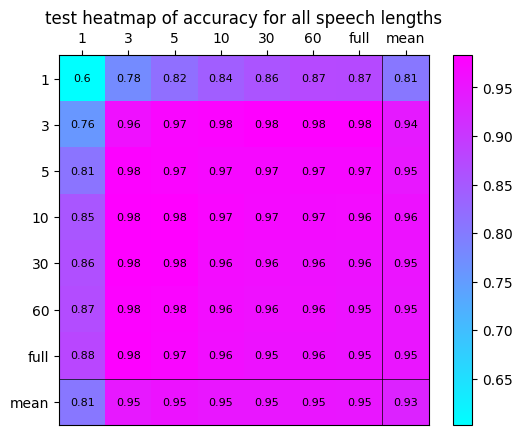

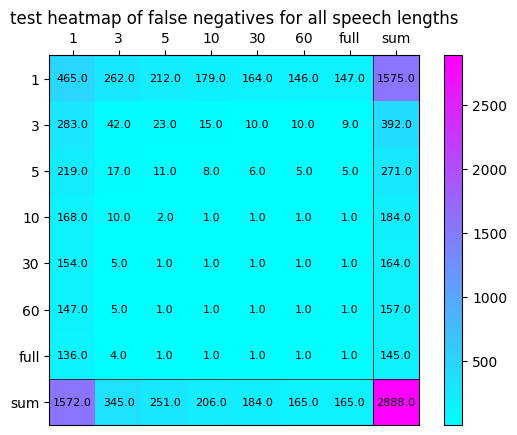

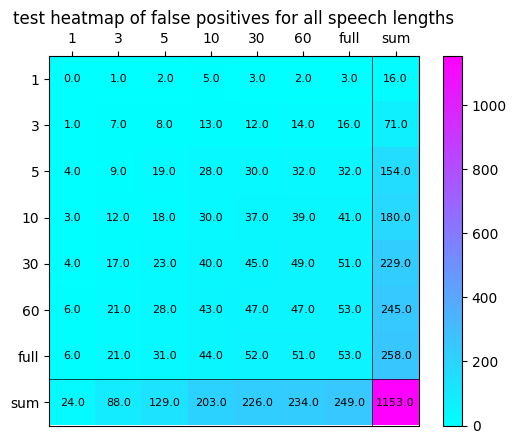

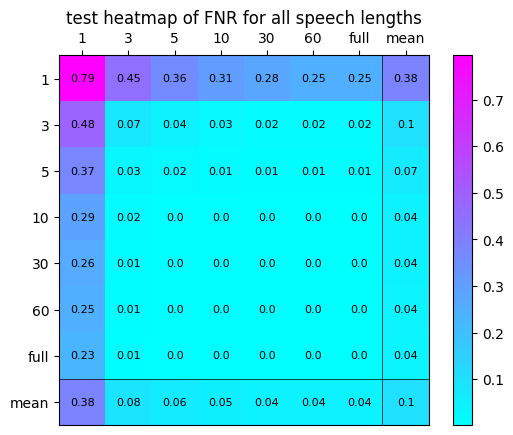

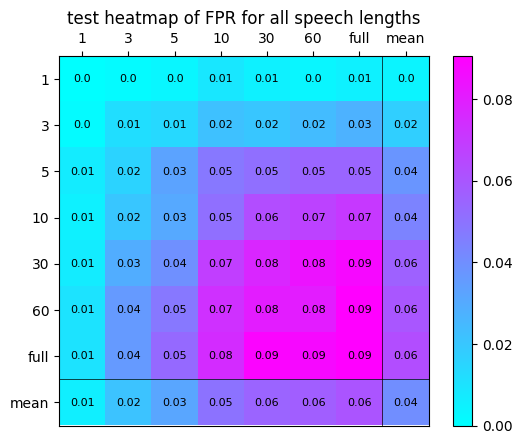

In [15]:
chart_diff_length_accuracies(test_overall_accuracies)
graph_diff_length_accuracies(test_overall_accuracies, "test")

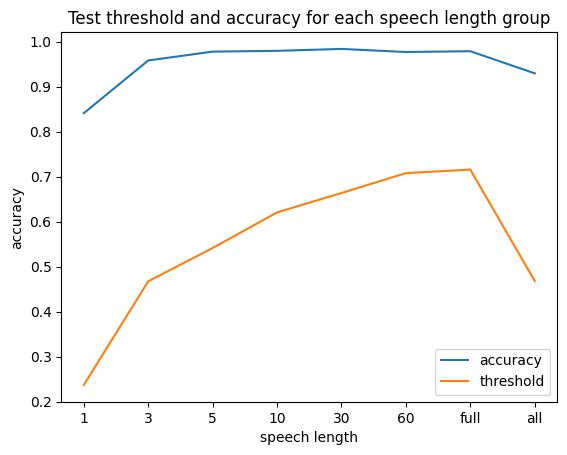

Speech length & Threshold & Accuracy \\
		\hline
		1 & 0.237 & 84.10 \\
		3 & 0.467 & 95.81 \\
		5 & 0.541 & 97.78 \\
		10 & 0.620 & 97.95 \\
		30 & 0.664 & 98.38 \\
		60 & 0.708 & 97.69 \\
		full & 0.716 & 97.86 \\
		all & 0.468 & 92.95 \\


In [16]:
def plot_acc_per_speech_length_thresh(overall_accuracies, split="test"):
    xs = speech_lengths[::-1] + ["all"]
    ys = [overall_accuracies[f"{speech_length}"][1] for speech_length in xs]
    threshes = [overall_accuracies[f"{speech_length}"][0] for speech_length in xs]
    plt.plot(xs, ys, label="accuracy")
    plt.plot(xs, threshes, label="threshold")
    plt.xlabel("speech length")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Test threshold and accuracy for each speech length group")
    plt.savefig(os.path.join(results_dir,
                             "within speaker graphs",
                             "test_acc_n_thresholds_per_speech_length.svg"),
                bbox_inches="tight")
    plt.show()
    plt.close()

    print("Speech length & Threshold & Accuracy \\\\\n\t\t\hline")
    for speech_length, threshold, accuracy in zip(xs, threshes, ys):
        print(f"\t\t{speech_length} & {threshold:.3f} & {accuracy*100:.2f} \\\\")
    
plot_acc_per_speech_length_thresh(test_overall_accuracies, "test")

In [17]:
def across_ages_accuracy(across_age_df, across_speaker_df, thresholds, num_pairs=3):
    scores = dict()
    across_age_df["age_diff"] = across_age_df[["age1", "age2"]].apply(lambda x: x.age2-x.age1, axis=1)
    across_speaker_df["age_diff"] = across_speaker_df[["age1", "age2"]].apply(lambda x: x.age2-x.age1, axis=1)
    for speech_length in speech_lengths:
        sub_scores = dict()
        threshold = thresholds[f"{speech_length}"][0]
        for age_diff in range(0, 9+1):
            across_age_preds = list(reduce(lambda x, y: x + y, 
                                            [across_age_df[across_age_df["age_diff"] == age_diff]
                                            [f"thresh_score_{i}_{speech_length}"].tolist() for i in range(1, num_pairs+1)]))
            across_speaker_preds = across_speaker_df[across_speaker_df["age_diff"] == age_diff][f"thresh_score_1_{speech_length}"].tolist()
            #
            all_preds = across_age_preds + across_speaker_preds
            all_true = [1 for _ in range(len(across_age_preds))] + [0 for _ in range(len(across_speaker_preds))]
            #
            accuracy = sum([1 if all_preds[i] == all_true[i] else 0 for i in range(len(all_true))])/len(all_true)
            #
            false_negs = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 1) else 0
                                for i in range(len(all_true))])
            fnr = false_negs/len(across_age_preds)
            #
            false_poss = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 0) else 0
                                for i in range(len(all_true))])
            fpr = false_poss/len(across_speaker_preds)
            #
            data = (threshold, accuracy, false_negs, false_poss, fnr, fpr)
            sub_scores[f"{age_diff}"] = data
        scores[f"{speech_length}"] = sub_scores
        
    sub_scores = dict()
    threshold = thresholds["all"][0]
    all_across_speaker_preds = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            all_across_speaker_preds += \
                across_speaker_df[f"thresh_score_1_{col_id}_all"].tolist()
            
    for age_diff in range(0, 9+1):
        all_across_age_preds = []
#         all_across_speaker_preds = []
        for speech_length_1 in speech_lengths:
            for speech_length_2 in speech_lengths:
                if speech_length_1 == speech_length_2:
                    col_id = f"{speech_length_1}"
                else:
                    col_id = f"{speech_length_1}_{speech_length_2}"
                    
                across_age_preds = list(reduce(lambda x, y: x + y, 
                                        [across_age_df[across_age_df["age_diff"] == age_diff]
                                        [f"thresh_score_{i}_{col_id}_all"].tolist() \
                                         for i in range(1, num_pairs+1)]))
                
#                 across_speaker_preds = \
#                     across_speaker_df[across_speaker_df["age_diff"] \
#                                       == age_diff][f"thresh_score_1_{col_id}_all"].tolist()
                
                all_across_age_preds += across_age_preds
#                 all_across_speaker_preds += across_speaker_preds
        num_preds = len(all_across_age_preds)
        all_preds = all_across_age_preds + all_across_speaker_preds
        all_true = [1 for _ in range(len(all_across_age_preds))] \
                 + [0 for _ in range(len(across_speaker_preds))]
        
        accuracy = sum([1 if all_preds[i] == all_true[i] else 0 \
                        for i in range(len(all_true))])/len(all_true)
        
        accuracy_same = sum([1 if all_preds[i] == all_true[i] else 0 \
                        for i in range(num_preds)])/num_preds
        
        accuracy_diff = sum([1 if all_preds[i] == all_true[i] else 0 \
                        for i in range(num_preds, len(all_true))])/(len(all_true) - num_preds)
        
        accuracy = (accuracy_same + accuracy_diff) / 2
        
        false_negs = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 1) else 0
                            for i in range(len(all_true))])
        fnr = false_negs/len(all_across_age_preds)
        
        false_poss = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 0) else 0
                            for i in range(len(all_true))])
        fpr = false_poss/len(across_speaker_preds)
        
        data = (threshold, accuracy, false_negs, false_poss, fnr, fpr)
        sub_scores[f"{age_diff}"] = data
#         print(len(all_across_age_preds), len(all_across_speaker_preds))
    scores["all"] = sub_scores
    return scores


test_across_ages_accuracies = across_ages_accuracy(test_across_age_df, test_across_speaker_df, scores, 3)

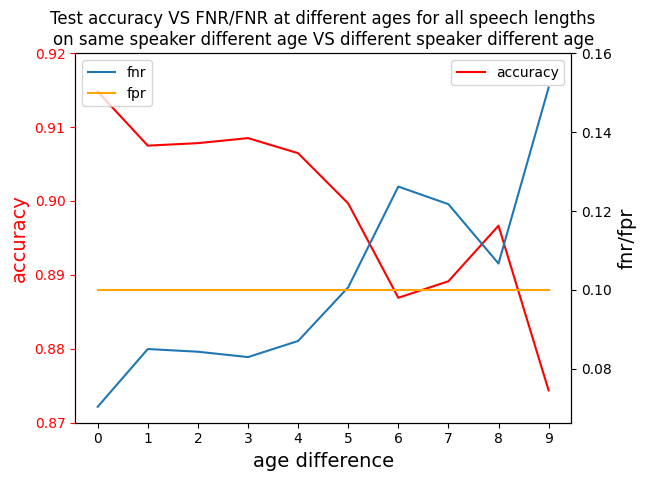

In [18]:
def plot_across_ages_accuracies(across_ages_accuracies, split="test"):    
    accs = [score[1] for score in across_ages_accuracies["all"].values()]
    fnrs = [score[4] for score in across_ages_accuracies["all"].values()]
    fprs = [score[5] for score in across_ages_accuracies["all"].values()]
    age_ranges = range(10)
    
    fig, ax = plt.subplots()
    ax.plot(age_ranges, accs, color="red", label="accuracy")
    ax.set_xlabel("age difference", fontsize = 14)
    ax.set_ylabel("accuracy",
                color="red",
                fontsize=14)
    ax.set_ylim(top=0.92)
    ax.spines['left'].set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='y', colors='red')
    ax.set_ylim(bottom=0.87)
    plt.legend(loc="upper right")
    
    ax2 = ax.twinx()
    ax2.plot(age_ranges, fnrs, label="fnr")
    ax2.set_ylabel("fnr/fpr",color="black",fontsize=14)
    
    ax2.plot(age_ranges, fprs, color="orange", label="fpr")
    ax2.set_ylim(top=0.16)
    plt.legend(loc="upper left")
    title = f"Test accuracy VS FNR/FNR at different ages for all speech lengths"
    subtitle = f"\non same speaker different age VS different speaker different age"
    plt.title(title+subtitle)
    plt.xticks(range(10))
    
    subdir = "acc vs fnr and fpr graphs"
    filename = f'{split}_acc_vs_fnr_n_fpr_across_age_VS_across_speaker_all_speech_lengths.svg'
    fig.savefig(os.path.join(results_dir, subdir, filename),
                bbox_inches='tight')
    
    plt.show()
    plt.close()
    
plot_across_ages_accuracies(test_across_ages_accuracies, split="test")

In [19]:
def per_bucket_accuracy(df_within, df_across, thresholds, num_pairs=3, bucket_size=5):
    scores = dict()
    min_age = df_across.age1.min()
    bucket_calc = lambda x: f"{(x-min_age)//bucket_size*5+min_age}-{(x-min_age)//bucket_size*5+min_age+4}"
    if "age" in df_within.columns:
        df_within["bucket"] = df_within["age"].apply(bucket_calc)
    else:
        df_within["bucket"] = df_within["age1"].apply(bucket_calc)
    df_across["bucket"] = df_across["age1"].apply(bucket_calc)
    num_buckets = df_within.bucket.max()
    buckets = sorted(list(set(df_within.bucket.tolist())))
    for speech_length in speech_lengths:
        sub_scores = dict()
        threshold = thresholds[f"{speech_length}"][0]
        for bucket in buckets:
            within_speaker_preds = list(reduce(lambda x, y: x + y, 
                                            [df_within[df_within["bucket"] == bucket][f"thresh_score_{i}_{speech_length}"].tolist() for i in range(1, num_pairs+1)]))
            across_speaker_preds = df_across[df_across["bucket"] == bucket][f"thresh_score_1_{speech_length}"].tolist()
            
            all_preds = within_speaker_preds + across_speaker_preds
            all_true = [1 for _ in range(len(within_speaker_preds))] + [0 for _ in range(len(across_speaker_preds))]
            
            accuracy = sum([1 if all_preds[i] == all_true[i] else 0 for i in range(len(all_true))])/len(all_true)
            
            false_negs = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 1) else 0
                                for i in range(len(all_true))])
            fnr = false_negs/len(within_speaker_preds)
            
            false_poss = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 0) else 0
                                for i in range(len(all_true))])
            fpr = false_poss/len(across_speaker_preds)
            
            data = (threshold, accuracy, false_negs, false_poss, fnr, fpr)
            sub_scores[f"{bucket}"] = data
        scores[f"{speech_length}"] = sub_scores
        
    threshold = thresholds["all"][0]
    sub_scores = dict()
    
    all_across_speaker_preds = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            all_across_speaker_preds += df_across[f"thresh_score_1_{col_id}_all"].tolist()
            
    for bucket in buckets:
        all_within_speaker_preds = []
#         all_across_speaker_preds = []
        for speech_length_1 in speech_lengths:
            for speech_length_2 in speech_lengths:
                if speech_length_1 == speech_length_2:
                    col_id = f"{speech_length_1}"
                else:
                    col_id = f"{speech_length_1}_{speech_length_2}"
                within_speaker_preds = list(reduce(lambda x, y: x + y, 
                                            [df_within[df_within["bucket"] == bucket][f"thresh_score_{i}_{col_id}_all"].tolist() for i in range(1, num_pairs+1)]))
#                 across_speaker_preds = df_across[df_across["bucket"] == bucket][f"thresh_score_1_{col_id}_all"].tolist()
                
                all_within_speaker_preds += within_speaker_preds
#                 all_across_speaker_preds += across_speaker_preds
                
        num_preds = len(all_within_speaker_preds)
        print(len(all_within_speaker_preds), len(all_across_speaker_preds))
        all_preds = all_within_speaker_preds + all_across_speaker_preds
        all_true = [1 for _ in range(len(all_within_speaker_preds))] \
                 + [0 for _ in range(len(all_across_speaker_preds))]
        
        accuracy = sum([1 if all_preds[i] == all_true[i] else 0 \
                        for i in range(len(all_true))])/len(all_true)
        
        accuracy_same = sum([1 if all_preds[i] == all_true[i] else 0 \
                        for i in range(0, num_preds)])/num_preds
        
        accuracy_diff = sum([1 if all_preds[i] == all_true[i] else 0 \
                        for i in range(num_preds, len(all_true))])/(len(all_true) - num_preds)
        
        accuracy = (accuracy_same + accuracy_diff) / 2
        
        false_negs = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 1) else 0
                            for i in range(len(all_true))])
        fnr = false_negs/len(all_within_speaker_preds)
        
        false_poss = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 0) else 0
                            for i in range(len(all_true))])
        fpr = false_poss/len(all_across_speaker_preds)
        
        data = (threshold, accuracy, false_negs, false_poss, fnr, fpr)
        sub_scores[f"{bucket}"] = data
    scores["all"] = sub_scores
            
    return scores


test_within_ages_bucket_accuracies = per_bucket_accuracy(test_within_age_df, test_across_speaker_df, scores, num_pairs=3)
test_across_ages_bucket_accuracies = per_bucket_accuracy(test_across_age_df, test_across_speaker_df, scores, num_pairs=3)

C:\Users\mayan\AppData\Local\Temp\ipykernel_8576\729253338.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_within["bucket"] = df_within["age"].apply(bucket_calc)


2352 28665
4704 28665
3528 28665
3381 28665
5292 28665
5880 28665
3528 28665
5880 28665
5880 28665
5880 28665
5880 28665
5145 28665


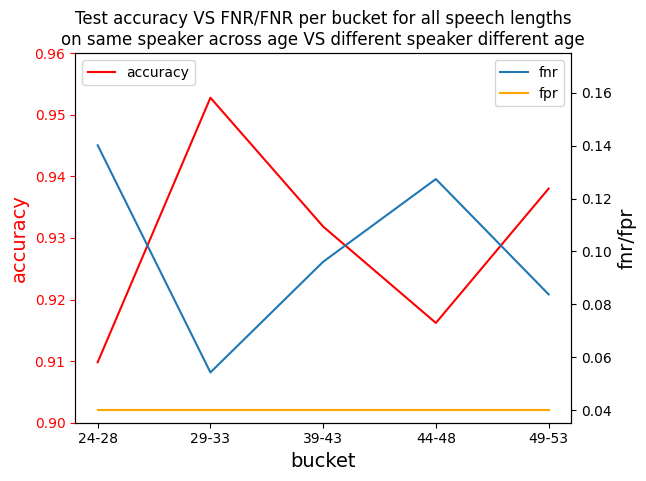

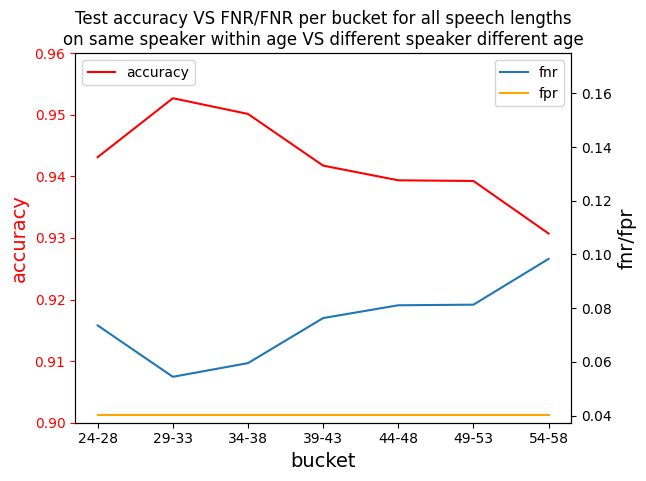

In [20]:
def plot_bucket_accuracies(bucket_accuracies, split="test", mode="within"):    
    accs = [score[1] for score in bucket_accuracies["all"].values()]
    fnrs = [score[4] for score in bucket_accuracies["all"].values()]
    fprs = [score[5] for score in bucket_accuracies["all"].values()]
    buckets = [bucket for bucket in bucket_accuracies["all"]]
    
    fig, ax = plt.subplots()
    ax.plot(buckets, accs, color="red", label="accuracy")
    ax.set_xlabel("bucket", fontsize = 14)
    ax.set_ylabel("accuracy",
                color="red",
                fontsize=14)
    ax.set_ylim(top=0.96)
    ax.spines['left'].set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='y', colors='red')
    ax.set_ylim(bottom=0.90)
    plt.legend(loc="upper left")
    
    ax2 = ax.twinx()
    ax2.plot(buckets, fnrs, label="fnr")
    ax2.set_ylabel("fnr/fpr",color="black",fontsize=14)
    
    ax2.plot(buckets, fprs, color="orange", label="fpr")
    ax2.set_ylim(top=0.175)
    plt.legend(loc="upper right")
    title = f"Test accuracy VS FNR/FNR per bucket for all speech lengths"
    subtitle = f"\non same speaker {mode} age VS different speaker different age"
    plt.title(title+subtitle)
    
    subdir = "acc vs fnr and fpr graphs"
    metric = "bucket_acc_vs_fnr_n_fpr"
    comparison = f"{mode}_age_VS_across_speaker"
    at_speech_length = "all_speech_lengths"
    filename = f'{split}_{metric}_{mode}_{comparison}_{at_speech_length}.svg'
    fig.savefig(os.path.join(results_dir, subdir, filename),
                bbox_inches='tight')
    
    plt.show()
    plt.close()
    
plot_bucket_accuracies(test_across_ages_bucket_accuracies, split="test", mode="across")
plot_bucket_accuracies(test_within_ages_bucket_accuracies, split="test", mode="within")

In [21]:
def within_vs_across_speaker_graphs(across_age_df, within_age_df, across_speaker_df, split="train", mode="across"):
    def make_graph(within_speaker_scores, across_speaker_scores, speech_length, age_mode):
        plt.hist(within_speaker_scores,
                 label=f"within speakers {age_mode} ages", alpha=0.5,
                 bins=np.arange(-0.2, 1.0, 0.02))
        
        plt.hist(across_speaker_scores,
                 label=f"across speakers {mode} ages", alpha=0.5,
                 bins=np.arange(-0.2, 1.0, 0.02))
        
        plt.legend()
        
        subdir = "within speaker vs across speaker graphs"
        comparison = "across speaker VS within speaker"
        ages = f"{age_mode} ages"
        metric = "cosine similarity scores"
        plural = "speech length" if speech_length != "all" else "speech lengths"
        at_speech_length = f"for {speech_length} speech length"
        title = f'{split} {comparison} {ages}\n{metric} {at_speech_length}'
        # plt.title(title)
        
        comparison = f"within_speaker_{age_mode}_age_VS_across_speaker"
        metric = "cossim_score"
        filename = f"{split}_{comparison}_{speech_length}_{metric}.svg"
        plt.savefig(os.path.join(results_dir, subdir, filename),
                    bbox_inches="tight")
        plt.close()
        
    with tqdm(speech_lengths, total=len(speech_lengths),
              desc=f"graphing across age mode per speech length") as graphing:
        for speech_length in graphing:
            graphing.set_postfix(speech_length=speech_length)
            within_speaker_scores = list(reduce(lambda x, y: x + y, 
                        [across_age_df[f"score_{i}_{speech_length}"].tolist() \
                         for i in range(1, NUM_PAIRS+1)]))
            across_speaker_scores = across_speaker_df[f"score_1_{speech_length}"].tolist()

            make_graph(within_speaker_scores, across_speaker_scores, speech_length, "across")
        
    with tqdm(speech_lengths, total=len(speech_lengths),
              desc=f"graphing withing age mode per speech length") as graphing:
        for speech_length in graphing:
            graphing.set_postfix(speech_length=speech_length)
            within_speaker_scores = list(reduce(lambda x, y: x + y, 
                        [within_age_df[f"score_{i}_{speech_length}"].tolist() \
                         for i in range(1, NUM_PAIRS+1)]))
            across_speaker_scores = across_speaker_df[f"score_1_{speech_length}"].tolist()

            make_graph(within_speaker_scores, across_speaker_scores, speech_length, "within")
      
    for df, age_mode in [(within_age_df, "within"), (across_age_df, "across")]:
        within_speaker_scores = []
        across_speaker_scores = []

        graphing = tqdm(speech_lengths, total=len(speech_lengths)*len(speech_lengths))
        graphing.set_description(f"graphing {age_mode} age mode for all speech lengths")
        
        for speech_length_1 in speech_lengths:
            for speech_length_2 in speech_lengths:
                graphing.set_postfix(speech_length_1=speech_length_1,
                                     speech_length_2=speech_length_2)
                if speech_length_1 == speech_length_2:
                    col_id = f"{speech_length_1}"
                else:
                    cold_id = f"{speech_length_1}_{speech_length_2}"
                within_speaker_scores += list(reduce(lambda x, y: x + y, 
                        [df[f"score_{i}_{col_id}"].tolist() \
                         for i in range(1, NUM_PAIRS+1)]))
                across_speaker_scores += across_speaker_df[f"score_1_{col_id}"].tolist()
                graphing.update(1)
        graphing.close()

        make_graph(within_speaker_scores, across_speaker_scores, "all", age_mode)


within_vs_across_speaker_graphs(train_across_age_df, train_within_age_df, train_across_speaker_df, split="train", mode="across")
within_vs_across_speaker_graphs(train_across_age_df, train_within_age_df, train_across_speaker_within_age_df, split="train", mode="within")

graphing across age mode for all speech lengths: 100%|██████████| 49/49 [00:00<00:00, 413.53it/s, speech_length_1=1, speech_length_2=1]


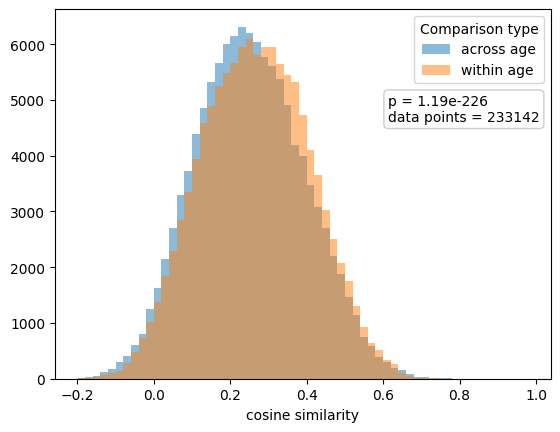

In [29]:
def across_speaker_within_vs_across_age_graphs(across_age_df, within_age_df, split="train"):
    props = dict(boxstyle='round', facecolor='white', alpha=0.2)
    stats_df = pd.DataFrame(columns=["comparison", "length", "mean_vp", "std_vp", "ci_lower", "ci_upper"])
    for speech_length in speech_lengths:
        across_age = across_age_df[f"score_1_{speech_length}"].tolist()
        within_age = within_age_df[f"score_1_{speech_length}"].tolist()
        plt.hist(across_age,
                label=f"across age", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
        plt.hist(within_age,
                label=f"within age", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
        #
        mean = np.mean(across_age)
        std = np.std(across_age)
        t = np.abs(stats.t.ppf((1-0.95)/2, len(across_age)-1))
        ci = (mean-std*t/np.sqrt(len(across_age)), mean+std*t/np.sqrt(len(across_age)))
        stats_dict = {"comparison": "across", "length": speech_length, "mean_vp": np.mean(across_age),
                      "std_vp": np.std(across_age), "ci_lower":ci[0], "ci_upper":ci[1]}
        stats_df = pd.concat([pd.DataFrame(stats_dict, index=[0]), stats_df]).reset_index(drop=True)
        mean = np.mean(within_age)
        std = np.std(within_age)
        t = np.abs(stats.t.ppf((1-0.95)/2, len(within_age)-1))
        ci = (mean-std*t/np.sqrt(len(within_age)), mean+std*t/np.sqrt(len(within_age)))
        stats_dict = {"comparison": "within", "length": speech_length, "mean_vp": np.mean(within_age),
                      "std_vp": np.std(within_age), "ci_lower":ci[0], "ci_upper":ci[1]}
        stats_df = pd.concat([pd.DataFrame(stats_dict, index=[0]), stats_df]).reset_index(drop=True)
        #
        stat, pvalue = stats.ttest_rel(across_age, within_age)
        text = f"p = {pvalue:.2e}"
        y_lim = plt.gca().get_ylim()[1]*0.95
        plt.text(0.05, y_lim, text, verticalalignment="top", bbox=props)
        plt.legend(title="Comparison type")
        plt.xlabel("cosine similarity")
        # plt.title(f'{split} across speaker within VS across age cosine similarity scores for {speech_length} speech length')
        plt.savefig(os.path.join(results_dir, 
                                 "within speaker graphs",
                                 f"{split}_across_speaker_across_VS_within_age_{speech_length}_cossim_score.svg"),
                    bbox_inches="tight")
        plt.close()
        
    across_age = []
    within_age = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            across_age += across_age_df[f"score_1_{col_id}"].tolist()
            within_age += within_age_df[f"score_1_{col_id}"].tolist()
            
    plt.hist(across_age,
                label=f"across age", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))
    plt.hist(within_age,
            label=f"within age", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))
    
    stat, pvalue = stats.ttest_rel(across_age, within_age)
    text = f"p = {pvalue:.2e}\ndata points = {len(across_age+within_age)}"
    y_lim = plt.gca().get_ylim()[1]*0.77
    x_lim = plt.gca().get_xlim()[1]*0.59
    plt.text(x_lim, y_lim, text, verticalalignment="top", bbox=props)
    plt.legend(title="Comparison type")
    
    comparison = "across speaker within VS across age"
    metric = "cosine similarity scores"
    at_speech_length = "for all speech lengths"
    title = f"{split} {comparison}\n{metric} {at_speech_length}"
    # plt.title(title)
    
    subdir = "within speaker graphs"
    comparison = "across_speaker_across_VS_within_age"
    at_speech_length = "all_speech_lengths"
    metric = "cossim_score"
    filename = f"{split}_{comparison}_{at_speech_length}_{metric}.svg"
    plt.xlabel("cosine similarity")
    plt.savefig(os.path.join(results_dir, subdir, filename),
                bbox_inches="tight")
    plt.show()
    plt.close()
    
    mean = np.mean(across_age)
    std = np.std(across_age)
    t = np.abs(stats.t.ppf((1-0.95)/2, len(across_age)-1))
    ci = (mean-std*t/np.sqrt(len(across_age)), mean+std*t/np.sqrt(len(across_age)))
    stats_dict = {"comparison": "across", "length": "all", "mean_vp": np.mean(across_age),
                  "std_vp": np.std(across_age), "ci_lower":ci[0], "ci_upper":ci[1]}
    stats_df = pd.concat([stats_df, pd.DataFrame(stats_dict, index=[0])]).reset_index(drop=True)
    mean = np.mean(within_age)
    std = np.std(within_age)
    t = np.abs(stats.t.ppf((1-0.95)/2, len(within_age)-1))
    ci = (mean-std*t/np.sqrt(len(within_age)), mean+std*t/np.sqrt(len(within_age)))
    stats_dict = {"comparison": "within", "length": "all", "mean_vp": np.mean(within_age),
                  "std_vp": np.std(within_age), "ci_lower":ci[0], "ci_upper":ci[1]}
    stats_df = pd.concat([stats_df, pd.DataFrame(stats_dict, index=[0])]).reset_index(drop=True)
    
    
    df = stats_df[stats_df.comparison=="within"]
    x = [f"{i}" for i in df["length"].tolist()]
    plt.plot(x, df["mean_vp"], label="same")
    plt.gca().fill_between(x, df["ci_lower"], df["ci_upper"], alpha=0.15)
    df = stats_df[stats_df.comparison=="across"]
    x = [f"{i}" for i in df["length"].tolist()]
    plt.plot(x, df["mean_vp"], label="different")
    plt.gca().fill_between(x, df["ci_lower"], df["ci_upper"], alpha=0.15)
    # plt.title(f'{split} cosine similarity score means for all speech lengths,\ndifferent speakers, same VS different age')
    plt.legend(title="age")
    plt.savefig(os.path.join(results_dir, 
                             "within speaker graphs",
                             f"{split}_across_speaker_same_VS_diff_age_means_cossim_score.svg"),
                bbox_inches="tight")
    plt.close()


across_speaker_within_vs_across_age_graphs(train_across_speaker_df, train_across_speaker_within_age_df, split="train")

speech length	statistic	p-value
----------------------------------------
         full	    -5.33	1.07e-07
           60	    -6.27	4.23e-10
           30	    -5.94	3.28e-09
           10	    -7.25	5.49e-13
            5	    -7.17	1.02e-12
            3	    -7.54	6.58e-14
            1	    -5.22	1.89e-07
          all	   -21.35	6.44e-101


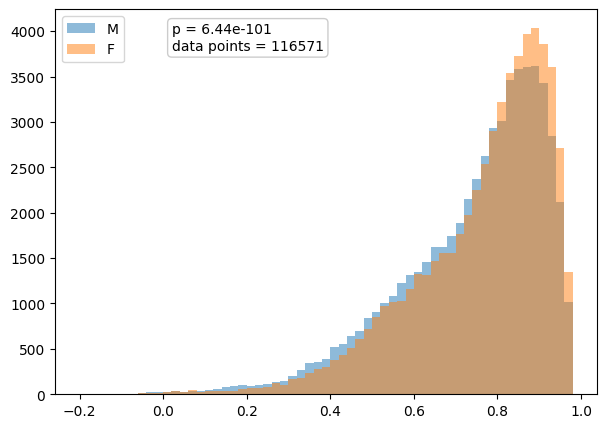

In [27]:
def compare_men_women_within_age(within_age_df, split, mode="within"):
    plt.rcParams['figure.figsize'] = [7, 5]
    print(f"speech length\tstatistic\tp-value\n----------------------------------------")
    props = dict(boxstyle='round', facecolor='white', alpha=0.2)
    for speech_length in speech_lengths:
        men = list(reduce(lambda x, y: x + y, [within_age_df[within_age_df.gender=="M"][
            f"score_{i}_{speech_length}"].tolist() for i in range(1, NUM_PAIRS+1)]))
        women = list(reduce(lambda x, y: x + y, [within_age_df[within_age_df.gender=="F"][
            f"score_{i}_{speech_length}"].tolist() for i in range(1, NUM_PAIRS+1)]))
        #
        stat, pvalue = stats.ttest_ind(men, women)
        text = f"p = {pvalue:.2e}"
        plt.hist(men,
                label="M", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
        plt.hist(women,
                label="F", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
        plt.legend(loc="upper left")
        y_lim = plt.gca().get_ylim()[1]*0.95
        plt.text(0.05, y_lim, text, verticalalignment="top", bbox=props)
        # plt.title(f'{split} within {mode} within ages, m VS f cosine similarity scores for {speech_length} speech length')
        plt.savefig(os.path.join(results_dir, "gender graphs", f"{split}_{mode}_speaker_within_age_m_VS_f_{speech_length}_cossim_score.svg"))
        plt.close()
        print(f"{speech_length:>13}\t{stat:>9.2f}\t{pvalue:>7.2e}")
        
    all_men = []
    all_women = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            men = list(reduce(lambda x, y: x + y, [within_age_df[within_age_df.gender=="M"][
            f"score_{i}_{col_id}"].tolist() for i in range(1, NUM_PAIRS+1)]))
            women = list(reduce(lambda x, y: x + y, [within_age_df[within_age_df.gender=="F"][
                f"score_{i}_{col_id}"].tolist() for i in range(1, NUM_PAIRS+1)]))
            
            all_men += men
            all_women += women
    stat, pvalue = stats.ttest_ind(all_men, all_women)
    text = f"p = {pvalue:.2e}\ndata points = {len(all_men+all_women)}"
    plt.hist(all_men,
            label="M", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
    plt.hist(all_women,
            label="F", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
    plt.legend(loc="upper left")
    y_lim = plt.gca().get_ylim()[1]*0.965
    x_lim = plt.gca().get_xlim()[1]*0.02
    plt.text(x_lim, y_lim, text, 
             horizontalalignment="left", verticalalignment="top", bbox=props)
    # plt.title(f'{split} within speaker within ages,\nm VS f cosine similarity scores for all speech lengths')
    plt.savefig(os.path.join(results_dir, 
                             "gender graphs", 
                             f"{split}_{mode}_speaker_within_age_m_VS_f_all_speech_lengths_cossim_score.svg"),
                bbox_inches="tight")
    print(f"{'all':>13}\t{stat:>9.2f}\t{pvalue:>7.2e}")
    plt.show()
    plt.close()


compare_men_women_within_age(train_within_age_df, "train")

speech length	statistic	p-value
----------------------------------------
         full	    18.35	1.87e-70
           60	    18.28	5.64e-70
           30	    18.10	1.11e-68
           10	    16.98	3.78e-61
            5	    15.61	2.13e-52
            3	    14.80	1.72e-47
            1	    10.05	2.70e-23
          all	    98.25	0.00e+00


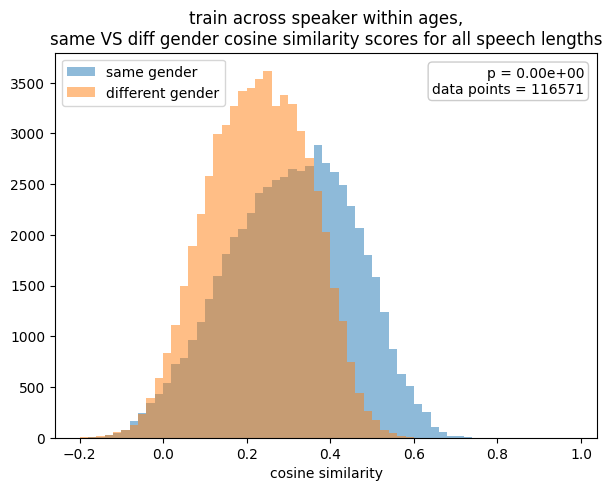

In [47]:
def compare_men_women_across_speaker(across_speaker_within_age_df, split):
    plt.rcParams['figure.figsize'] = [7, 5]
    print(f"speech length\tstatistic\tp-value\n----------------------------------------")
    props = dict(boxstyle='round', facecolor='white', alpha=0.2)
    NUM_PAIRS=1
    stats_df = pd.DataFrame(columns=["comparison", "length", "mean_vp", "std_vp", "ci_lower", "ci_upper"])
    for speech_length in speech_lengths:
        same_gender = list(reduce(lambda x, y: x + y, [across_speaker_within_age_df[
            (across_speaker_within_age_df.gender1==across_speaker_within_age_df.gender2)][
            f"score_{i}_{speech_length}"].tolist() for i in range(1, NUM_PAIRS+1)]))
        men_vs_women = list(reduce(lambda x, y: x + y, [across_speaker_within_age_df[
            (across_speaker_within_age_df.gender1!=across_speaker_within_age_df.gender2)][
            f"score_{i}_{speech_length}"].tolist() for i in range(1, NUM_PAIRS+1)]))
        #
        mean = np.mean(same_gender)
        std = np.std(same_gender)
        t = np.abs(stats.t.ppf((1-0.95)/2, len(same_gender)-1))
        ci = (mean-std*t/np.sqrt(len(same_gender)), mean+std*t/np.sqrt(len(same_gender)))
        stats_dict = {"comparison": "same", "length": speech_length, "mean_vp": np.mean(same_gender),
                      "std_vp": np.std(same_gender), "ci_lower":ci[0], "ci_upper":ci[1]}
        stats_df = pd.concat([pd.DataFrame(stats_dict, index=[0]), stats_df]).reset_index(drop=True)
        mean = np.mean(men_vs_women)
        std = np.std(men_vs_women)
        t = np.abs(stats.t.ppf((1-0.95)/2, len(men_vs_women)-1))
        ci = (mean-std*t/np.sqrt(len(men_vs_women)), mean+std*t/np.sqrt(len(men_vs_women)))
        stats_dict = {"comparison": "diff", "length": speech_length, "mean_vp": np.mean(men_vs_women),
                      "std_vp": np.std(men_vs_women), "ci_lower":ci[0], "ci_upper":ci[1]}
        stats_df = pd.concat([pd.DataFrame(stats_dict, index=[0]), stats_df]).reset_index(drop=True)
        stat, pvalue = stats.ttest_ind(same_gender, men_vs_women)
        text = f"p = {pvalue:.2e}"
        plt.hist(same_gender,
                label="same gender", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
        plt.hist(men_vs_women,
                label="different gender", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
        plt.legend(loc="upper left")
        y_lim = plt.gca().get_ylim()[1]*0.95
        plt.text(0.70, y_lim, text, verticalalignment="top", bbox=props)
        # plt.title(f'{split} across speaker within ages,\nsame VS diff gender cosine similarity scores for {speech_length} speech length')
        plt.savefig(os.path.join(results_dir, 
                                 "gender graphs",
                                 f"{split}_across_speaker_within_age_same_VS_diff_gender_{speech_length}_cossim_score.svg"))
        plt.close()
        print(f"{speech_length:>13}\t{stat:>9.2f}\t{pvalue:>7.2e}")
        #
    df = stats_df[stats_df.comparison=="same"]
    x = [f"{i}" for i in df["length"].tolist()]
    plt.plot(x, df["mean_vp"], label="same gender")
    plt.gca().fill_between(x, df["ci_lower"], df["ci_upper"], alpha=0.15)
    df = stats_df[stats_df.comparison=="diff"]
    x = [f"{i}" for i in df["length"].tolist()]
    plt.plot(x, df["mean_vp"], label="different gender")
    plt.gca().fill_between(x, df["ci_lower"], df["ci_upper"], alpha=0.15)
    # plt.title(f'{split} cosine similarity score means for all speech lengths,\ndifferent speakers, same ages, same VS diff gender')
    plt.legend()
    plt.savefig(os.path.join(results_dir, 
                             "gender graphs",
                             f"{split}_across_speaker_within_age_same_VS_diff_gender_means_cossim_score.svg"))
    plt.close()
    
    all_same_gender = []
    all_men_vs_women = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            same_gender = list(reduce(lambda x, y: x + y, [across_speaker_within_age_df[
                (across_speaker_within_age_df.gender1==across_speaker_within_age_df.gender2)][
                f"score_{i}_{col_id}"].tolist() for i in range(1, NUM_PAIRS+1)]))
            men_vs_women = list(reduce(lambda x, y: x + y, [across_speaker_within_age_df[
                (across_speaker_within_age_df.gender1!=across_speaker_within_age_df.gender2)][
                f"score_{i}_{col_id}"].tolist() for i in range(1, NUM_PAIRS+1)]))
            all_same_gender += same_gender
            all_men_vs_women += men_vs_women
            
    stat, pvalue = stats.ttest_ind(all_same_gender, all_men_vs_women)
    print(f"{'all':>13}\t{stat:>9.2f}\t{pvalue:>7.2e}")
    
    text = f"p = {pvalue:.2e}\ndata points = {len(all_same_gender + all_men_vs_women)}"
    plt.hist(all_same_gender,
            label="same gender", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
    plt.hist(all_men_vs_women,
            label="different gender", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))#, histtype="step")
    plt.legend(loc="upper left")
    y_lim = plt.gca().get_ylim()[1]*0.965
    x_lim = plt.gca().get_xlim()[1]*0.97
    plt.xlabel("cosine similarity")
    plt.text(x_lim, y_lim, text, 
             horizontalalignment="right", verticalalignment="top", bbox=props)
    plt.title(f'{split} across speaker within ages,\nsame VS diff gender cosine similarity scores for all speech lengths')
    plt.savefig(os.path.join(results_dir, 
                             "gender graphs",
                             f"{split}_across_speaker_within_age_same_VS_diff_gender_all_speech_lengths_cossim_score.svg"),
                bbox_inches="tight")
    plt.show()
    plt.close()


compare_men_women_across_speaker(train_across_speaker_within_age_df, "train")

In [29]:
def per_gender_accuracy(df_within, df_across, thresholds, num_pairs=3):
    scores = dict()
    threshold = thresholds["all"][0]
    
    across_speaker_preds = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            
            across_speaker_preds += df_across[f"thresh_score_1_{col_id}_all"].tolist()
    
    df_within["age_diff"] = df_within[["age1", "age2"]].apply(lambda x: x.age2-x.age1, axis=1)
    gender_col = "gender" if "gender" in df_within.columns else "gender1"
    for gender in ["M", "F"]:
        sub_scores = dict()
        for age_diff in range(9+1):
            within_speaker_preds = []
            for speech_length_1 in speech_lengths:
                for speech_length_2 in speech_lengths:
                    if speech_length_1 == speech_length_2:
                        col_id = f"{speech_length_1}"
                    else:
                        col_id = f"{speech_length_1}_{speech_length_2}"

                    within_speaker_preds += list(reduce(lambda x, y: x + y, 
                        [df_within[(df_within[gender_col] == gender) & (df_within["age_diff"] == age_diff)][\
                        f"thresh_score_{i}_{col_id}_all"].tolist() \
                        for i in range(1, num_pairs+1)]))

            num_preds = len(within_speaker_preds)
            all_preds = within_speaker_preds + across_speaker_preds
            all_true = [1 for _ in range(len(within_speaker_preds))] \
                     + [0 for _ in range(len(across_speaker_preds))]

            accuracy_same = sum([1 if all_preds[i] == all_true[i] else 0 \
                            for i in range(num_preds)])/num_preds

            accuracy_diff = sum([1 if all_preds[i] == all_true[i] else 0 \
                            for i in range(num_preds, len(all_true))])/\
                            (len(all_true)-num_preds)

            accuracy = (accuracy_same + accuracy_diff) / 2

            false_negs = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 1) else 0
                                for i in range(len(all_true))])
            fnr = false_negs/len(within_speaker_preds)

            false_poss = sum([1 if (all_preds[i] != all_true[i]) and (all_true[i] == 0) else 0
                                for i in range(len(all_true))])
            fpr = false_poss/len(across_speaker_preds)

            data = (threshold, accuracy, false_negs, false_poss, fnr, fpr)
            sub_scores[f"{age_diff}"] = data
        scores[f"{gender}"] = sub_scores
            
    return scores


# test_within_ages_gender_accuracies = per_gender_accuracy(test_within_age_df, 
#                                                          test_across_speaker_df, 
#                                                          scores, num_pairs=3)
test_across_ages_gender_accuracies = per_gender_accuracy(test_across_age_df, 
                                                         test_across_speaker_df, 
                                                         scores, num_pairs=3)

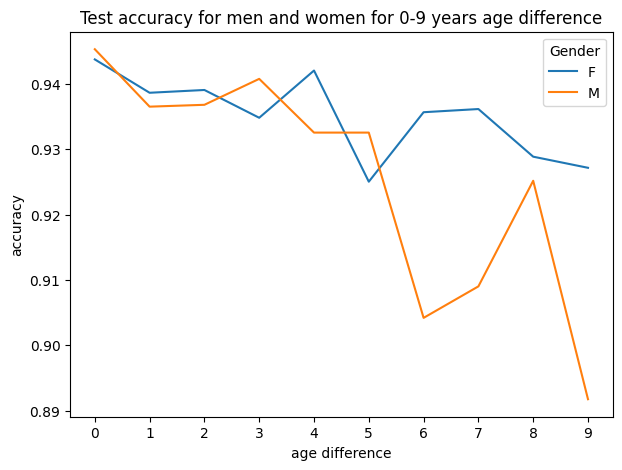

In [48]:
def plot_gender_accuracies(gender_accuracies, split="test", mode="within"):  
#     print(gender_accuracies.keys())
    for gender in ["F", "M"]:
        accs = [score[1] for score in gender_accuracies[gender].values()]
#         print(accs)
        fnrs = [score[4] for score in gender_accuracies[gender].values()]
        fprs = [score[5] for score in gender_accuracies[gender].values()]
        genders = [gender for gender in gender_accuracies]
        plt.plot(accs, label=gender)
    plt.legend(title="Gender")
    plt.xticks(range(9+1))

    title = f"Test accuracy for men and women for 0-9 years age difference"
    subtitle = f"\non same speaker {mode} age VS different speaker different age"
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("age difference")
    
    subdir = "gender graphs"
    metric = "gender_acc"
    comparison = f"{mode}_age_VS_across_speaker"
    at_speech_length = "all_speech_lengths"
    filename = f'{split}_{metric}_{mode}_{comparison}_{at_speech_length}.svg'
    plt.savefig(os.path.join(results_dir, subdir, filename),
                bbox_inches='tight')
    
    plt.show()
    plt.close()
    
plot_gender_accuracies(test_across_ages_gender_accuracies, split="test", mode="across")
# plot_gender_accuracies(test_within_ages_gender_accuracies, split="test", mode="within")

In [31]:
# print overall_accuracies
def print_overall_accuracies(overall_accuracies):
    print(f"{'length':>6}\t{'threshold':>9}\t{'accuracy':>8}\t{'false_negs':>10}\t{'false_poss':>10}\t{'fnr':>5}\t{'fpr':>5}")
    for key, value in overall_accuracies.items(): 
        print(f"{key:>6}\t{value[0]*100:>9.2f}\t{value[1]*100:>8.2f}\t{value[2]:>10}\t{value[3]:>10}\t{value[4]*100:>5.2f}\t{value[5]*100:>5.2f}")
    print()

print_overall_accuracies(train_overall_accuracies)
print_overall_accuracies(dev_overall_accuracies)
print_overall_accuracies(test_overall_accuracies)

length	threshold	accuracy	false_negs	false_poss	  fnr	  fpr
  full	    71.56	   99.52	        21	         2	 0.88	 0.08
    60	    70.77	   99.45	        23	         3	 0.97	 0.13
    30	    66.35	   99.58	        16	         4	 0.67	 0.17
    10	    62.04	   98.99	        37	        11	 1.56	 0.46
     5	    54.13	   98.21	        56	        29	 2.35	 1.22
     3	    46.72	   96.15	       116	        67	 4.88	 2.82
     1	    23.70	   84.83	       401	       321	16.86	13.49
full_full	    46.80	   92.50	         0	       357	 0.00	15.01
full_60	    46.80	   92.69	         0	       348	 0.00	14.63
full_30	    46.80	   92.90	         0	       338	 0.00	14.21
full_10	    46.80	   94.39	         0	       267	 0.00	11.22
full_5	    46.80	   95.50	         3	       211	 0.13	 8.87
full_3	    46.80	   96.32	        11	       164	 0.46	 6.89
full_1	    46.80	   88.36	       499	        55	20.98	 2.31
60_full	    46.80	   92.88	         0	       339	 0.00	14.25
 60_60	    46.80	   93.04	       

In [32]:
def print_comparison_accuracies(bucket_accuracies, split="train", mode="across", thresh_base="across", comparison="age_range"):
    """comparison: "age_range" or "age_diff" (age difference)
    mode: "across" or "within" (always "across" when "comparison"=="age_diff)"""
    stats_df = pd.DataFrame(columns=[comparison, "length", "accuracy", "threshold"])
    print("-"*(6+9+9+8+10+10+5+5+(7*7)))
    for key, value in bucket_accuracies.items():
        print(f"{'length':>6}\t{comparison:>9}\t{'threshold':>9}\t{'accuracy':>8}\t{'false_negs':>10}\t{'false_poss':>10}\t{'fnr':>5}\t{'fpr':>5}")
        for bucket_key, bucket_value in value.items():
            print(f"{key:>6}\t{bucket_key:>9}\t{bucket_value[0]*100:>9.2f}\t{bucket_value[1]*100:>8.2f}\t{bucket_value[2]:>10}\t{bucket_value[3]:>10}\t{bucket_value[4]*100:>5.2f}\t{bucket_value[5]*100:>5.2f}")
            accuracy = bucket_value[1]
            # std = np.std(same_gender)
            # t = np.abs(stats.t.ppf((1-0.95)/2, len(same_gender)-1))
            # ci = (mean-std*t/np.sqrt(len(same_gender)), mean+std*t/np.sqrt(len(same_gender)))
            stats_dict = {comparison: bucket_key, "length": key, "accuracy": accuracy*100, "threshold": bucket_value[0]*100}
            stats_df = pd.concat([stats_df, pd.DataFrame(stats_dict, index=[0])]).reset_index(drop=True)
        print("-"*(6+9+9+8+10+10+5+5+(7*7)))
        #
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    length_col = ["speech length"] + speech_lengths
    threshold_col = ["threshold"]
    line_col = [extra]
    label_empty = [""]
    # fig, ax = plt.subplots(1, 1)
    for speech_length in speech_lengths:
        df = stats_df[stats_df.length==f"{speech_length}"]
        x = [f"{i}" for i in df[comparison].tolist()]
        # print(df.columns, "\n", df.head())
        threshold = df.threshold.iloc[0]
        threshold_col.append(f"{threshold:.2f}")
        img, = plt.plot(x, df["accuracy"], label=f'{f"{speech_length}, {threshold:.2f}":>20}')
        line_col.append(img)
        # plt.gca().fill_between(x, df["ci_lower"], df["ci_upper"], alpha=0.15)
    # plt.title(f'{split} accuracy for all speech lengths,\ndifferent speakers for {thresh_base} thresh base')
    legend_handle = line_col + 3 * len(threshold_col) * [extra]
    legend_labels = np.concatenate([label_empty * len(length_col), label_empty * len(length_col), length_col, threshold_col])
    plt.legend(legend_handle, legend_labels, ncol=4, handletextpad=-2, bbox_to_anchor=(1,1))
    plt.gca().set_xlabel(" ".join(comparison.split("_")))
    plt.gca().set_ylabel("accuracy")
    # sns.move_legend(plt.gca(), "center left", bbox_to_anchor=(1,0.5))
    plt.savefig(os.path.join(results_dir, f"{split}_within_speaker_{mode}_age_{thresh_base}_thresh_base_{comparison}_all_lengths_accuracy_curves.svg"), bbox_inches="tight")
    plt.close()

print_comparison_accuracies(test_across_ages_accuracies, "test", "across", "across", "age_diff")
print_comparison_accuracies(test_across_ages_bucket_accuracies, "test", "across", "across")
print_comparison_accuracies(test_within_ages_bucket_accuracies, "test", "within", "across")

---------------------------------------------------------------------------------------------------------------
length	 age_diff	threshold	accuracy	false_negs	false_poss	  fnr	  fpr
  full	        0	    71.56	   98.65	         1	         0	 1.67	 0.00
  full	        1	    71.56	   98.70	         1	         0	 1.67	 0.00
  full	        2	    71.56	   97.33	         2	         0	 3.33	 0.00
  full	        3	    71.56	  100.00	         0	         0	 0.00	 0.00
  full	        4	    71.56	   98.70	         1	         0	 1.67	 0.00
  full	        5	    71.56	   94.59	         4	         0	 6.67	 0.00
  full	        6	    71.56	   95.89	         3	         0	 5.00	 0.00
  full	        7	    71.56	   93.24	         5	         0	 8.77	 0.00
  full	        8	    71.56	   97.06	         2	         0	 3.51	 0.00
  full	        9	    71.56	   91.55	         6	         0	11.76	 0.00
---------------------------------------------------------------------------------------------------------------
length

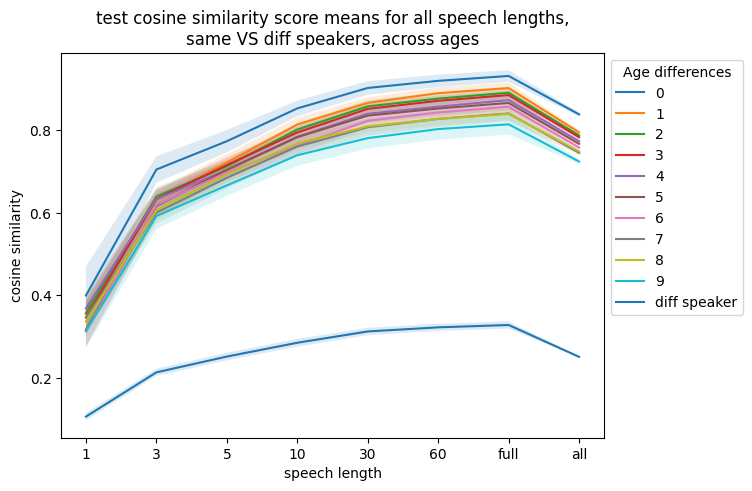

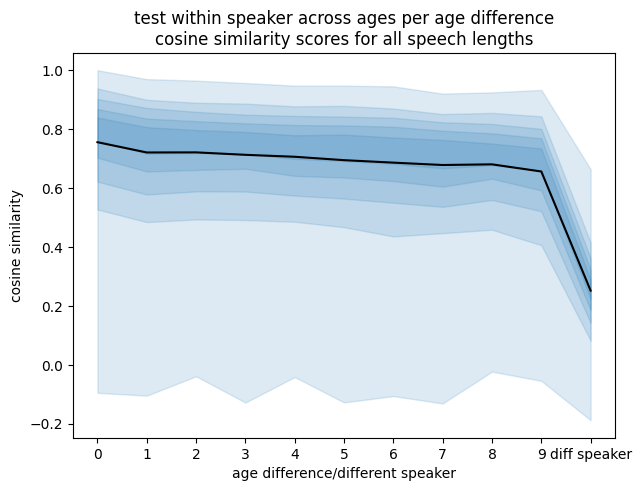

In [37]:
def across_ages_graph(across_age_df, across_speaker_df, thresholds, split="train", num_pairs=3):
    scores = dict()
    across_age_df["age_diff"] = across_age_df[["age1", "age2"]].apply(lambda x: x.age2-x.age1, axis=1)
    across_speaker_df["age_diff"] = across_speaker_df[["age1", "age2"]].apply(lambda x: x.age2-x.age1, axis=1)
    stats_df = pd.DataFrame(columns=["length", "age_diff", "mean_vp", "std_vp", "ci_lower", "ci_upper"])
    for speech_length in speech_lengths:
        sub_scores = dict()
        # threshold = thresholds[f"{speech_length}"][0]
        for age_diff in range(0, 9+1):
            across_age_preds = list(reduce(lambda x, y: x + y, 
                                            [across_age_df[across_age_df["age_diff"] == age_diff]
                                            [f"score_{i}_{speech_length}"].tolist() for i in range(1, num_pairs+1)]))
            mean = np.mean(across_age_preds)
            std = np.std(across_age_preds)
            t = np.abs(stats.t.ppf((1-0.95)/2, len(across_age_preds)-1))
            ci = (mean-std*t/np.sqrt(len(across_age_preds)), mean+std*t/np.sqrt(len(across_age_preds)))
            stats_dict = {"speaker": "same", "length": speech_length, "age_diff": age_diff, "mean_vp": np.mean(across_age_preds),
                        "std_vp": np.std(across_age_preds), "ci_lower":ci[0], "ci_upper":ci[1]}
            stats_df = pd.concat([pd.DataFrame(stats_dict, index=[0]), stats_df]).reset_index(drop=True)
            plt.hist(across_age_preds, label=f"{age_diff}, count={len(across_age_preds)}", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))
        across_speaker_preds = list(reduce(lambda x, y: x + y, 
                                    [across_speaker_df#[across_speaker_df["age_diff"] == age_diff]
                                    [f"score_{i}_{speech_length}"].tolist() for i in range(1, 1+1)]))
        mean = np.mean(across_speaker_preds)
        std = np.std(across_speaker_preds)
        t = np.abs(stats.t.ppf((1-0.95)/2, len(across_speaker_preds)-1))
        ci = (mean-std*t/np.sqrt(len(across_speaker_preds)), mean+std*t/np.sqrt(len(across_speaker_preds)))
        stats_dict = {"speaker": "diff", "length": speech_length, "age_diff": age_diff, "mean_vp": np.mean(across_speaker_preds),
                    "std_vp": np.std(across_speaker_preds), "ci_lower":ci[0], "ci_upper":ci[1]}
        stats_df = pd.concat([pd.DataFrame(stats_dict, index=[0]), stats_df]).reset_index(drop=True)
        plt.legend(title="age differences")
        # plt.title(f'{split} within speaker cosine similarities for {speech_length} speech length')
        plt.savefig(os.path.join(results_dir, "unneeded", f"{split}_within_speaker_across_age_{speech_length}_cossim_score.svg"))
        plt.close()
        
    age_diffs = dict([(i, []) for i in range(10)])
    for age_diff in range(0, 9+1):
        across_age_preds = []
        for speech_length_1 in speech_lengths:
            for speech_length_2 in speech_lengths:
                if speech_length_1 == speech_length_2:
                    col_id = f"{speech_length_1}"
                else:
                    cold_id = f"{speech_length_1}_{speech_length_2}"
                    
                across_age_preds += list(reduce(lambda x, y: x + y, 
                                         [across_age_df[across_age_df["age_diff"] == age_diff]
                                         [f"score_{i}_{col_id}"].tolist() \
                                          for i in range(1, num_pairs+1)]))
        
        mean = np.mean(across_age_preds)
        std = np.std(across_age_preds)
        t = np.abs(stats.t.ppf((1-0.95)/2, len(across_age_preds)-1))
        ci = (mean-std*t/np.sqrt(len(across_age_preds)), 
              mean+std*t/np.sqrt(len(across_age_preds)))
        
        stats_dict = {"speaker": "same", "length": "all", 
                      "age_diff": age_diff, "mean_vp": np.mean(across_age_preds), 
                      "std_vp": np.std(across_age_preds), "ci_lower":ci[0], "ci_upper":ci[1]}
        
        stats_df = pd.concat([
            stats_df, pd.DataFrame(stats_dict, index=[0])]).reset_index(drop=True)
    
    across_speaker_preds = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            across_speaker_preds += list(reduce(lambda x, y: x + y, 
                                        [across_speaker_df
                                        [f"score_{i}_{col_id}"].tolist() for i in range(1, 1+1)]))
    mean = np.mean(across_speaker_preds)
    std = np.std(across_speaker_preds)
    t = np.abs(stats.t.ppf((1-0.95)/2, len(across_speaker_preds)-1))
    ci = (mean-std*t/np.sqrt(len(across_speaker_preds)), 
          mean+std*t/np.sqrt(len(across_speaker_preds)))
    
    stats_dict = {"speaker": "diff", "length": "all", 
                  "age_diff": age_diff, "mean_vp": np.mean(across_speaker_preds),
                "std_vp": np.std(across_speaker_preds), "ci_lower":ci[0], "ci_upper":ci[1]}
    
    stats_df = pd.concat([
        stats_df, pd.DataFrame(stats_dict, index=[0])]).reset_index(drop=True)
    
        
    speech_length = "full"
    within_age_preds = list(reduce(lambda x, y: x + y, 
                                    [across_age_df[across_age_df["age_diff"] == 0]
                                    [f"score_{i}_{speech_length}"].tolist() for i in range(1, num_pairs+1)]))
    for age_diff in range(1, 9+1):
        across_age_preds = list(reduce(lambda x, y: x + y, 
                                        [across_age_df[across_age_df["age_diff"] == age_diff]
                                        [f"score_{i}_{speech_length}"].tolist() for i in range(1, num_pairs+1)]))
        across_speaker_preds = list(reduce(lambda x, y: x + y, 
                                        [across_speaker_df#[across_speaker_df["age_diff"] == age_diff]
                                        [f"score_{i}_{speech_length}"].tolist() for i in range(1, 1+1)]))
        plt.hist(within_age_preds, label=f"0, within speaker, count={len(within_age_preds)}", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))
        plt.hist(across_age_preds, label=f"{age_diff}, within speaker, count={len(across_age_preds)}", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))
        plt.hist(across_speaker_preds, label=f"all ages, across speaker, count={len(across_speaker_preds)}", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))
        plt.gca().set_ylim(0, 50)
        plt.legend(title="age differences")
        # plt.title(f'{split} within and across speaker across ages cosine similarities for {age_diff} year age difference')
        plt.savefig(os.path.join(results_dir, 
                                 "within speaker graphs", 
                                 f"{split}_within_speaker_across_age_{age_diff}_age_diff_cossim_score.svg"))
        plt.close()
        
    for age_diff in range(0, 9+1):
    # for speech_length in speech_lengths:
        df = stats_df[(stats_df.age_diff==age_diff) & (stats_df.speaker=="same")]
        x = [f"{i}" for i in df["length"].tolist()]
        plt.plot(x, df["mean_vp"], label=f"{age_diff}")
        plt.gca().fill_between(x, df["ci_lower"], df["ci_upper"], alpha=0.15)
    df = stats_df[(stats_df.age_diff==age_diff) & (stats_df.speaker=="diff")]
    x = [f"{i}" for i in df["length"].tolist()]
    plt.plot(x, df["mean_vp"], label=f"diff speaker")
    plt.gca().fill_between(x, df["ci_lower"], df["ci_upper"], alpha=0.15)
    plt.title(f'{split} cosine similarity score means for all speech lengths,\nsame VS diff speakers, across ages')
    plt.legend(title="Age differences", bbox_to_anchor=(1,1))
    plt.xlabel("speech length")
    plt.ylabel("cosine similarity")
    plt.savefig(os.path.join(results_dir, 
                             "within speaker vs across speaker graphs",
                             f"{split}_within_speaker_across_age_all_speech_lengths_means_cossim_score.svg"),
                bbox_inches="tight")
    plt.show()
    plt.close()
    
    stats_df = pd.DataFrame(columns=["age_diff", "mean_vp", "vp_lower", "vp_upper"])
    for age_diff in range(0, 9+1):
        age_cossims = []
        for speech_length_1 in speech_lengths:
            for speech_length_2 in speech_lengths:
                if speech_length_1 == speech_length_2:
                    col_id = f"{speech_length_1}"
                else:
                    col_id = f"{speech_length_1}_{speech_length_2}"
                age_cossims += list(reduce(lambda x, y: x + y, 
                                         [across_age_df[across_age_df["age_diff"] == age_diff]
                                         [f"score_{i}_{col_id}"].tolist() \
                                          for i in range(1, num_pairs+1)]))
#         plt.hist(age_cossims,
#             label=f"{age_diff}", alpha=0.5, bins=np.arange(-0.2, 1, 0.02))
        mean = np.mean(age_cossims)
        vp_lower = min(age_cossims)
        vp_upper = max(age_cossims)
        
        stats_dict = {"age_diff": age_diff, "mean_vp": mean, 
                      "vp_lower": vp_lower, "vp_upper": vp_upper}
        
        for percentile in range(10, 100, 10):
            stats_dict[percentile] = np.percentile(age_cossims, percentile)
        
        stats_df = pd.concat([
            stats_df, pd.DataFrame(stats_dict, index=[0])]).reset_index(drop=True)
    
    across_speaker_preds = []
    for speech_length_1 in speech_lengths:
        for speech_length_2 in speech_lengths:
            if speech_length_1 == speech_length_2:
                col_id = f"{speech_length_1}"
            else:
                col_id = f"{speech_length_1}_{speech_length_2}"
            across_speaker_preds += list(reduce(lambda x, y: x + y, 
                                        [across_speaker_df
                                        [f"score_{i}_{col_id}"].tolist() for i in range(1, 1+1)]))
    mean_across = np.mean(across_speaker_preds)
    vp_lower = min(across_speaker_preds)
    vp_upper = max(across_speaker_preds)
    
    stats_dict = {"age_diff": "diff speaker", "mean_vp": mean_across, 
                  "vp_lower": vp_lower, "vp_upper": vp_upper}
    
    for percentile in range(10, 100, 10):
        stats_dict[percentile] = np.percentile(across_speaker_preds, percentile)

    stats_df = pd.concat([
        stats_df, pd.DataFrame(stats_dict, index=[0])]).reset_index(drop=True)
    
#     for age_diff in range(0, 9+1):
#     # for speech_length in speech_lengths:
#         df = stats_df[(stats_df.age_diff==age_diff) & (stats_df.speaker=="same")]
#         x = [f"{i}" for i in df["length"].tolist()]
#         plt.plot(x, df["mean_vp"], label=f"{age_diff}")
#         plt.gca().fill_between(x, df["ci_lower"], df["ci_upper"], alpha=0.15)
    df = stats_df#[(stats_df.age_diff==age_diff) & (stats_df.speaker=="diff")]
    x = [f"{i}" for i in stats_df["age_diff"].tolist()]
    plt.plot(x, df["mean_vp"], color="k")#, label=f"diff speaker")
    plt.gca().fill_between(x, df["vp_lower"], df["vp_upper"], alpha=0.15, color='#1f77b4')
    for percentile in range(10, 50, 10):
        plt.gca().fill_between(x, df[percentile], 
                               df[100-percentile], alpha=0.15, color='#1f77b4')
#     plt.legend(title="Age differences", bbox_to_anchor=(1,1))
    plt.xlabel("age difference/different speaker")
    plt.ylabel("cosine similarity")
    plt.title(f'{split} within speaker across ages per age difference\ncosine similarity scores for all speech lengths')
    plt.savefig(os.path.join(results_dir, 
                             "within speaker vs across speaker graphs",
                             f"{split}_within_speaker_across_age_VS_across_speaker_all_speech_lengths_cossim_score.svg"),
                bbox_inches="tight")
    plt.show()
    plt.close()
            

across_ages_graph(test_across_age_df, test_across_speaker_df, scores, split="test")

In [34]:
scores_within_age_across_speaker = get_best_threshold_n_roc(train_within_age_df, train_across_speaker_within_age_df, "train", 3, mode="within")
# thresh_scores = vary_threshold_graph(train_within_age_df, train_across_speaker_within_age_df, "train", 3, mode="within")
# add_threshold_accs_to_df(train_within_age_df, train_across_age_df, train_across_speaker_within_age_df, scores, 3)
# add_threshold_accs_to_df(dev_within_age_df, dev_across_age_df, dev_across_speaker_within_age_df, scores, 3)
# add_threshold_accs_to_df(test_within_age_df, test_across_age_df, test_across_speaker_within_age_df, scores, 3)
# train_overall_accuracies = overall_accuracy(train_across_age_df, train_across_speaker_within_age_df, scores, 3)
# dev_overall_accuracies = overall_accuracy(dev_across_age_df, dev_across_speaker_within_age_df, scores, 3)
# test_overall_accuracies = overall_accuracy(test_across_age_df, test_across_speaker_within_age_df, scores, 3)
# test_across_ages_accuracies = across_ages_accuracy(test_across_age_df, test_across_speaker_df, scores, 3)
# test_within_ages_bucket_accuracies = per_bucket_accuracy(test_within_age_df, test_across_speaker_within_age_df, scores, num_pairs=3)
# test_across_ages_bucket_accuracies = per_bucket_accuracy(test_across_age_df, test_across_speaker_within_age_df, scores, num_pairs=3)

# print_comparison_accuracies(test_across_ages_accuracies, "test", "across", "within", "age_diff")
# print_comparison_accuracies(test_across_ages_bucket_accuracies, "test", "across", "within")
# print_comparison_accuracies(test_within_ages_bucket_accuracies, "test", "within", "within")

# print_overall_accuracies(train_overall_accuracies)
# print_overall_accuracies(dev_overall_accuracies)
# print_overall_accuracies(test_overall_accuracies)

0.07483851043570036


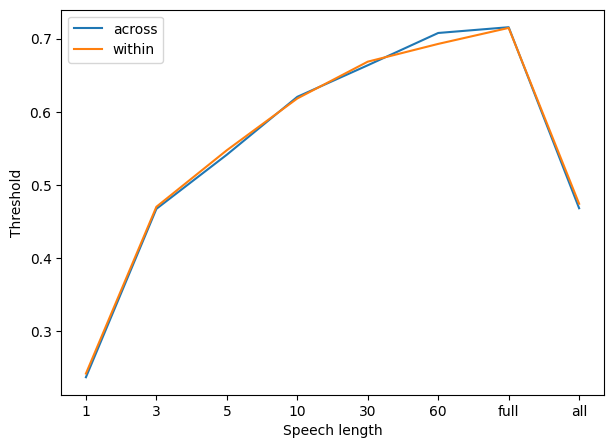

In [35]:
def plot_thresh_differences(across_age_scores, within_age_scores):
    xs = speech_lengths[::-1] + ["all"]
    across_age_ys = [across_age_scores[f"{sl}"][0] for sl in xs]
    within_age_ys = [within_age_scores[f"{sl}"][0] for sl in xs]
    
    plt.plot(xs, across_age_ys, label="across")
    plt.plot(xs, within_age_ys, label="within")
    plt.legend()
    # plt.title("Thresholds computed\nusing within and across age across speaker groups")
    plt.xlabel("Speech length")
    plt.ylabel("Threshold")
    plt.savefig(os.path.join(results_dir,
                             "thresholds_within_VS_across_age_across_speaker.svg"),
                bbox_inches="tight")
    plt.show()
    
plot_thresh_differences(scores, scores_within_age_across_speaker)